<a href="https://colab.research.google.com/github/mattthelee/nlp-labs/blob/master/nnnlpLab10/Lab10_colabversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 10: Dialogue Act Tagging

Dialogue act (DA) tagging is an important step in the process of developing dialog systems. DA tagging is a problem usually solved by supervised machine learning approaches that all require large amounts of hand labeled data. A wide range of techniques have been investigated for DA tagging. In this lab, we explore two models for DA classification. We are using the Switchboard Dialog Act Corpus for training.
Corpus can be downloaded from http://compprag.christopherpotts.net/swda.html.


The downloaded dataset should be kept in a data folder in the same directory as this file. 

In [1]:
import pandas as pd
import glob
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import pickle
import tensorflow as tf
from tqdm import tqdm


# tf.enable_eager_execution()


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

f = glob.glob("/content/gdrive/My Drive/swda/sw*/sw*.csv")
frames = []
for i in range(0, len(f)):
    frames.append(pd.read_csv(f[i]))

result = pd.concat(frames, ignore_index=True)




Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
print("Number of converations in the dataset:",len(result))


Number of converations in the dataset: 223606


The dataset has many different features, we are only using act_tag and text for this training.


In [0]:
reduced_df = result[['act_tag','text']]


In [5]:
reduced_df.head()


,act_tag,text
0,qo,"Um, so what do you think? /"
1,^h,"Um, -/"
2,x,<Baby_talking>.
3,sd,"I lived, I lived in Sweden for two years. /"
4,b,Uh-huh. /


Theere are 43 tags in this dataset. Some of the tags are Yes-No-Question('qy'), Statement-non-opinion('sd') and Statement-opinion('sv'). Tags information can be found here http://compprag.christopherpotts.net/swda.html#tags. 


You can check the frequency of tags.

In [6]:
act_tag_counts = reduced_df['act_tag'].value_counts()
# Reduce the number of classes by replacing rare labels with the 'other' token
# By reducing the number i help to reduce the class imbalance 
# and also scale the confusion matrix down to a size that allows for interpretation
threshold = 100
for label in act_tag_counts.keys():
    if act_tag_counts[label] < threshold:
        reduced_df.replace(label,'other', inplace=True)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Baseline BiLSTM Model

To get unique tags. 

In [0]:
unique_tags = set()
for tag in reduced_df['act_tag']:
    unique_tags.add(tag)

In [0]:
# Load the onehot encoding dataframe from disk to avoid re-runs incorrectly mapping vectors
import os.path
fname = "one_hot_encoding_dic.pickle"
if os.path.isfile(fname) and False:
    pickle_in = open(fname,"rb")
    one_hot_encoding_dic = pickle.load(pickle_in)
else:
    one_hot_encoding_dic = pd.get_dummies(list(unique_tags))


pickle_out = open(fname,"wb")
pickle.dump(one_hot_encoding_dic, pickle_out)
pickle_out.close()

In [0]:
tags_encoding = []
for i in range(0, len(reduced_df)):
    tags_encoding.append(one_hot_encoding_dic[reduced_df['act_tag'].iloc[i]])

The tags are one hot encoded.

To create sentence embeddings:

In [0]:
sentences = []
for i in range(0, len(reduced_df)):
    sentences.append(reduced_df['text'].iloc[i].split(" "))


In [0]:
wordvectors = {}
index = 1
for s in sentences:
    for w in s:
        if w not in wordvectors:
            wordvectors[w] = index
            index += 1

In [12]:
MAX_LENGTH = len(max(sentences, key=len))
#MAX_LENGTH = 150
# needs to be an even number of tensorflow reshaping to work
if MAX_LENGTH % 2 == 1:
    MAX_LENGTH += 1
print(MAX_LENGTH)

138


In [0]:
sentence_embeddings = []
for s in sentences:
    sentence_emb = []
    for w in s:
        sentence_emb.append(wordvectors[w])
    sentence_embeddings.append(sentence_emb)


Then we split the dataset into test and train.

In [0]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings, np.array(tags_encoding))


And pad the sentences with zero to make all sentences of equal length.


In [0]:
from keras.preprocessing.sequence import pad_sequences
 
train_sentences_X = pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')

 The model architecture is as follows: Embedding Layer (to generate word embeddings) Next layer Bidirectional LSTM. Feed forward layer with number of neurons = number of tags. Softmax activation to get probabilities.

In [16]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout, InputLayer, Bidirectional, TimeDistributed, Activation, Embedding
from keras.optimizers import Adam
#Building the network
numberOfTags = len(reduced_df['act_tag'].value_counts())
embed_dim = 50

model = Sequential()
model.add(Embedding(len(wordvectors)+1, output_dim=embed_dim, input_length=MAX_LENGTH))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(numberOfTags,activation='softmax' ))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model.summary()
weightsFilePath ="/content/gdrive/My Drive/weights.best.hdf5"

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 138, 50)           2186600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               58880     
_________________________________________________________________
dense_1 (Dense)              (None, 58)                7482      
Total params: 2,252,962
Trainable params: 2,252,962
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Save the best weights to a file so we get the model with the best val acc

checkpoint = ModelCheckpoint(weightsFilePath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit(train_sentences_X,y_train,epochs=5,batch_size=512,validation_data=(test_sentences_X, y_test), callbacks=[checkpoint],verbose=1)


Instructions for updating:
Use tf.cast instead.
Train on 167704 samples, validate on 55902 samples
Epoch 1/5
167704/167704 [==============================] - 220s 1ms/step - loss: 1.9609 - acc: 0.4981 - val_loss: 1.4567 - val_acc: 0.6168

Epoch 00001: val_acc improved from -inf to 0.61676, saving model to /content/gdrive/My Drive/weights.best.hdf5
Epoch 2/5
167704/167704 [==============================] - 218s 1ms/step - loss: 1.3088 - acc: 0.6459 - val_loss: 1.2258 - val_acc: 0.6616

Epoch 00002: val_acc improved from 0.61676 to 0.66164, saving model to /content/gdrive/My Drive/weights.best.hdf5
Epoch 3/5
167704/167704 [==============================] - 218s 1ms/step - loss: 1.1249 - acc: 0.6880 - val_loss: 1.1511 - val_acc: 0.6711

Epoch 00003: val_acc improved from 0.66164 to 0.67114, saving model to /content/gdrive/My Drive/weights.best.hdf5
Epoch 4/5
167704/167704 [==============================] - 218s 1ms/step - loss: 1.0181 - acc: 0.7133 - val_loss: 1.1141 - val_acc: 0.6800

Ep

In [23]:
model.load_weights(weightsFilePath)
score = model.evaluate(test_sentences_X, y_test, batch_size=100)

55902/55902 [==============================] - 120s 2ms/step


In [24]:
bfTotal = 0.0
brTotal = 0.0
sdTotal = 0.0
for i,row in enumerate(y_test):
    if np.array_equal(row,one_hot_encoding_dic['br']):
        brTotal += 1.0
    elif np.array_equal(row,one_hot_encoding_dic['bf']):
        bfTotal += 1.0
    elif np.array_equal(row,one_hot_encoding_dic['sd']):
        sdTotal += 1.0
        
print(bfTotal)
print(brTotal)
print(sdTotal)

254.0
52.0
17675.0


In [25]:
for i,key in enumerate(one_hot_encoding_dic.keys()):
    if key == 'br':
        brConfusionMatrixIndex = i
    elif key == 'bf':
        bfConfusionMatrixIndex = i
    elif key == 'sd':
        sdConfusionMatrixIndex = i
print(brConfusionMatrixIndex)
print(bfConfusionMatrixIndex)
print(sdConfusionMatrixIndex)

19
16
45


In [0]:
y_pred = model.predict(test_sentences_X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  This is separate from the ipykernel package so we can avoid doing imports until


br Accuracy: 0.3269230769230769, bf accuracy: 0.0,sd Accuracy: 0.8264214992927864 
Overall accuracy: 68.10132016743587
The br was most commonly confused with: 
b
qw
+
other
The bf was most commonly confused with: 
qy
%
+
sv
sd


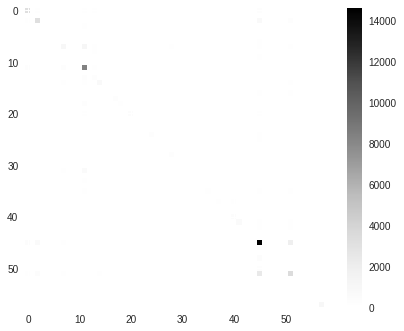

<Figure size 576x396 with 0 Axes>

In [46]:
# Create dict to convert y vectors back to strings
vec_to_string = {}
for key in one_hot_encoding_dic.keys():
    vec_to_string[one_hot_encoding_dic[key].argmax()] = key

y_pred_strings = []
for vec in y_pred:
    y_pred_strings.append(vec_to_string[vec.argmax()])

y_test_strings = []
for vec in y_test:
    y_test_strings.append(vec_to_string[vec.argmax()])
    
cm = confusion_matrix(y_test_strings,y_pred_strings, labels=one_hot_encoding_dic.keys())
brAccuracy = float(cm[brConfusionMatrixIndex][brConfusionMatrixIndex] )/ float(brTotal)
bfAccuracy = float(cm[bfConfusionMatrixIndex][bfConfusionMatrixIndex]) / float(bfTotal)
sdAccuracy = float(cm[sdConfusionMatrixIndex][sdConfusionMatrixIndex]) / float(sdTotal)
print(f"br Accuracy: {brAccuracy}, bf accuracy: {bfAccuracy},sd Accuracy: {sdAccuracy} ")
print(f"Overall accuracy: {np.diag(cm).sum()*100.0 / len(y_test)}")

brCommonMistakes = cm[brConfusionMatrixIndex]
brTop5MistakesIndices = brCommonMistakes.argsort()[-5:]
print("The br was most commonly confused with: ")
for index in brTop5MistakesIndices:
  if index == brConfusionMatrixIndex:
    continue
  print(one_hot_encoding_dic.keys()[index])

bfCommonMistakes = cm[bfConfusionMatrixIndex]
bfTop5MistakesIndices = bfCommonMistakes.argsort()[-5:]
print("The bf was most commonly confused with: ")
for index in bfTop5MistakesIndices:
  if index == bfConfusionMatrixIndex:
    continue
  print(one_hot_encoding_dic.keys()[index])


# The br and bf sentences are incorrectly labelled as "other" and sd most commonly. 
# I think this is because they are some of the most common classes in the dataset.
# The 0% accuracy for bf was concerning so i decided to plot thw whole confusion matrix to see what was happening
# The confusion matrix is mostly dark with a small number of bright dots. These are the classes it tries to classify
# This indicates that the large class imbalance has caused the model to only output a small number of classes rather than the full range
# It simply accepts it will get the other classes wrong as it is still able to achieve good (>60%) accuracy without using them
plt.imshow(cm)
plt.colorbar()

plt.show()

plt.savefig("/content/gdrive/My Drive/confusionmatrix.png")


In addition to overall accuracy, you need to look at the accuracy of some minority classes. Signal-non-understanding ('br') is a good indicator of "other-repair" or cases in which the other conversational participant attempts to repair the speaker's error. Summarize/reformulate ('bf') has been used in dialogue summarization. Report the accuracy for these classes and some frequent errors you notice the system makes in predicting them. What do you think the reasons are？


As the dataset is highly imbalanced, we can simply weight up the minority classes proportionally to their underrepresentation while training. 

In [0]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(tags_encoding, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
classBalancedWeightsFilePath = "/content/gdrive/My Drive/classBalancedweights.best.hdf5"

In [48]:

classBalancedCheckpoint = ModelCheckpoint(classBalancedWeightsFilePath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
model.fit(train_sentences_X, y_train, batch_size=512, epochs=5, class_weight = d_class_weights, validation_data=(test_sentences_X, y_test), callbacks=[classBalancedCheckpoint])

Train on 167704 samples, validate on 55902 samples
Epoch 1/5
167704/167704 [==============================] - 216s 1ms/step - loss: 1.6683 - acc: 0.4981 - val_loss: 2.1139 - val_acc: 0.4371

Epoch 00001: val_acc improved from -inf to 0.43710, saving model to /content/gdrive/My Drive/classBalancedweights.best.hdf5
Epoch 2/5
167704/167704 [==============================] - 216s 1ms/step - loss: 1.4821 - acc: 0.5014 - val_loss: 2.0329 - val_acc: 0.4474

Epoch 00002: val_acc improved from 0.43710 to 0.44741, saving model to /content/gdrive/My Drive/classBalancedweights.best.hdf5
Epoch 3/5
167704/167704 [==============================] - 216s 1ms/step - loss: 1.3375 - acc: 0.5132 - val_loss: 2.0904 - val_acc: 0.4444

Epoch 00003: val_acc did not improve from 0.44741
Epoch 4/5
167704/167704 [==============================] - 214s 1ms/step - loss: 1.2332 - acc: 0.5231 - val_loss: 1.9711 - val_acc: 0.4650

Epoch 00004: val_acc improved from 0.44741 to 0.46505, saving model to /content/gdrive/M

Report the overall accuracy and the accuracy of  'br' and 'bf'  classes. Suggest other ways to handle imbalanced classes.

Can we improve things by using context information?  Next we try to build a model which predicts DA tag from the sequence of 
previous DA tags, plus the utterance representation. 

##Using Context for Dialog Act Classification
We expect there is valuable sequential information among the DA tags. So in this section we apply a BiLSTM on top of the sentence CNN representation. The CNN model learns textual information in each sentence for DA classification. Here, we use bidirectional-LSTM (BLSTM) to learn the context before and after the current sentence. The left-to-right LSTM output and the one from the reverse direction are concatenated and input to a hidden layer for classification.

Functions for creating weights and biases.

In [0]:
def weights_init(shape):
    return tf.Variable(tf.truncated_normal(shape=shape, stddev=0.05))

In [0]:
def bias_init(shape):
    return tf.Variable(tf.zeros(shape=shape))


 This is classical CNN layer used to convolve over embedings tensor and gether useful information from it. The data is represented by hierarchy of features, which can be modelled using a CNN.
    
      Input(s): 
              input - word_embedings
              filter_size - size of width and height of the Conv kernel
              number_of_channels - in this case it is always 1
              number_of_filters - how many representation of the input utterance are we going to output from this layer 
              strides - how many does kernel move to the side and up/down
              activation - a activation function
              max_pool - boolean value which will trigger a max_pool operation on the output tensor
      Output(s): 
               text_conv layer
    

In [0]:
def text_conv(input, filter_size, number_of_channels, number_of_filters, strides=(1, 1), activation=tf.nn.relu, max_pool=True):
    #print('Conv')
    #print(input)
    #print(filter_size)
    #print('conv end')
    weights = weights_init([filter_size, filter_size, number_of_channels, number_of_filters])
    print(tf.shape(input))
    bias = bias_init([number_of_filters])
    print('bias done')
    layer = tf.nn.conv2d(input, filter=weights, strides=[1, strides[0], strides[1], 1], padding='SAME')
    print('done')
    if activation != None:
        layer = activation(layer)
    print('this works')
    if max_pool:
        layer = tf.nn.max_pool(layer, ksize=[1, 2, 2 ,1], strides=[1, 2, 2, 1], padding='SAME')
    
    return layer

    This method is used to create LSTM layer. And the data we’re working with has temporal properties which we want to model as well — hence the use of a LSTM. You can create a BiLSTM by modifying this.
    
    Input(s): lstm_cell_unitis - used to define the number of units in a LSTM layer
              number_of_layers - used to define how many of LSTM layers do we want in the network
              batch_size - in this method this information is used to build starting state for the network
              dropout_rate - used to define how many cells in a layer do we want to 'turn off'
              
    Output(s): cell - lstm layer
               init_state - zero vectors used as a starting state for the network

In [0]:
def lstm_layer(lstm_size, number_of_layers, batch_size, dropout_rate):

    def cell(size, dropout_rate=None):
        layer = tf.contrib.rnn.BasicLSTMCell(lstm_size)
        
        return tf.contrib.rnn.DropoutWrapper(layer, output_keep_prob=dropout_rate)
            
    cell = tf.contrib.rnn.MultiRNNCell([cell(lstm_size, dropout_rate) for _ in range(number_of_layers)])
    
    init_state = cell.zero_state(batch_size, tf.float32)
    return cell, init_state

    Use to transform/reshape conv output to 2d matrix, if it's necessary
    
    Input(s): Layer - text_cnn layer
              batch_size - how many samples do we feed at once
              seq_len - number of time steps
              
    Output(s): reshaped_layer - the layer with new shape
               number_of_elements - this param is used as a in_size for next layer

In [0]:
def flatten(layer, batch_size, seq_len):

    dims = layer.get_shape()
    number_of_elements = dims[2:].num_elements()
    
    reshaped_layer = tf.reshape(layer, [batch_size, int(seq_len/2), number_of_elements])
    return reshaped_layer, number_of_elements

    Output layer for the lstm netowrk
    
    Input(s): lstm_outputs - outputs from the RNN part of the network
              input_size - in this case it is RNN size (number of neuros in RNN layer)
              output_size - number of neuros for the output layer == number of classes
              
    Output(s) - logits, 

In [0]:
def dense_layer(input, in_size, out_size, dropout=False, activation=tf.nn.relu):
  
    weights = weights_init([in_size, out_size])
    bias = bias_init([out_size])
    
    layer = tf.matmul(input, weights) + bias
    
    if activation != None:
        layer = activation(layer)
    
    if dropout:
        layer = tf.nn.dropout(layer, 0.5)
        
    return layer

    Function used to calculate loss and minimize it
    
    Input(s): rnn_out - logits from the fully_connected layer
              targets - targets used to train network
              learning_rate/step_size
    
    
    Output(s): optimizer - optimizer of choice
               loss - calculated loss function

In [0]:
def loss_optimizer(logits, targets, learning_rate ):
    loss =tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=targets))
    print(loss)
    print(targets)
    print(logits)

    print(learning_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    return loss, optimizer

To create the model you can use these inputs:     
       
       Input(s): learning_rate/step_size - how fast are we going to find global minima
                  batch_size -  the nuber of samples to feed at once
                  seq_len - the number of timesteps in unrolled RNN
                  vocab_size - the number of nunique words in the vocab
                  embed_size - length of word embed vectors
                  conv_filters - number of filters in output tensor from CNN layer
                  conv_filter_size - height and width of conv kernel
                  number_of_lstm_layers - the number of layers used in the LSTM part of the network
                  lstm_units - the number of neurons/cells in a LSTM layer

In [0]:
class DATagging(object):
    
    def __init__(self, learning_rate=0.001, batch_size=100, seq_len=250, vocab_size=10000, embed_size=300,
                conv_filters=32, conv_filter_size=5, number_of_lstm_layers=1, lstm_units=128):
        
        # Clear tf graph for multiple cell running
        tf.reset_default_graph()
        
        # Create placeholders
        self.inputSentences = tf.placeholder(tf.int32, [batch_size, seq_len], name='inputSentences')
        self.targetLabels= tf.placeholder(tf.float32, [batch_size, numberOfTags], name='targetLabels')    

        
        
        #Embedding layer
        # Initialise word embeddings with random uniform dist
        wordEmbeddings = tf.Variable(tf.random_uniform([vocab_size, embed_size]))
        # Embedding layer
        embeddingLayer = tf.nn.embedding_lookup(wordEmbeddings, self.inputSentences)
        
        # Reshape embedding layer to have a "channel"
        embeddingLayer = tf.expand_dims(embeddingLayer, -1)

        # Conv layer
        number_of_channels = 1
        sentence_embedding = text_conv(embeddingLayer, conv_filter_size,number_of_channels, conv_filters)
        flat_sentence_embedding, size = flatten(sentence_embedding, batch_size, seq_len)
        
        
        lstm_cell, init_state = lstm_layer(lstm_units, number_of_lstm_layers, batch_size, dropout_rate = 0.3)

        
        # BiLSTM layers
        
        (outputs,states) = tf.nn.bidirectional_dynamic_rnn(lstm_cell,
                                                       lstm_cell, 
                                                       flat_sentence_embedding,
                                                       dtype=tf.float32)
        
        
        # Need to reshape the outputs to be include only the last output from the sequence, 
        # but every instance in batch and every lstm output
        (forwardOutputs,backwardOutputs) = outputs
        reshapedForward = tf.squeeze(tf.slice(forwardOutputs, [0,0,0],[-1,1,-1]))
        reshapedBackward = tf.squeeze(tf.slice(backwardOutputs, [0,0,0],[-1,1,-1]))
        shapedOutputs = tf.concat([reshapedForward,reshapedBackward], 1)
        # Hidden layer, with relu activation as we want it to output word embeddings
        denseLayer = dense_layer(shapedOutputs, lstm_units*2, numberOfTags)
        
        #print(denseLayer)
        #print(self.targetLabels)
        self.loss, self.optimizer = loss_optimizer(denseLayer, self.targetLabels, learning_rate)
        
        predictions = tf.math.argmax(denseLayer, axis = 1)
        labels = tf.argmax(self.targetLabels, axis = 1)
        #print(predictions)
        #print(labels)
        
        self.accuracy = tf.metrics.accuracy(labels, predictions)[1]

In [0]:
def shuffleData(x_train,y_train):
    # Returns a shuffled batch of x and y data
    indices = np.random.permutation(len(x_train))
    x_train_shuffled = x_train[indices]
    y_train_shuffled = y_train[indices]
    return x_train_shuffled, y_train_shuffled


In [0]:
batch_size = 256
model2 = DATagging(learning_rate=0.001, 
                     batch_size=batch_size, 
                     seq_len=MAX_LENGTH, 
                     vocab_size=len(wordvectors) + 1, 
                     embed_size=50,
                     conv_filters=32, 
                     conv_filter_size=5, 
                     number_of_lstm_layers=1, 
                     lstm_units=128)

session = tf.Session()
session.run(tf.global_variables_initializer())
session.run(tf.local_variables_initializer())
epochs = 5
for i in range(epochs):
    epoch_loss = []
    train_accuracy = []
    for ii in tqdm(range(0, len(train_sentences_X), batch_size)):
        x_train_shuffled, y_train_shuffled = shuffleData(train_sentences_X,y_train)
        X_batch = x_train_shuffled[ii:ii+batch_size]
        y_batch = y_train_shuffled[ii:ii+batch_size]
        if len(y_batch) < batch_size:
            # If we are at the end of the data, take  batch from teh end, 
            # this repeats some data but allows us to use all of it
            X_batch = x_train_shuffled[-batch_size:]
            y_batch = y_train_shuffled[-batch_size:]
        
        c, _, a = session.run([model2.loss, model2.optimizer, model2.accuracy], feed_dict={model2.inputSentences:X_batch, 
                                                                                  model2.targetLabels:y_batch})
        print(f"Accuracy: {a}")
        epoch_loss.append(c)
        train_accuracy.append(a)
        
    
    print("Epoch: {}/{}".format(i, epochs), " | Epoch loss: {}".format(np.mean(epoch_loss)), 
          " | Mean train accuracy: {}".format(np.mean(train_accuracy)))
#model2.summary()
#history = model2.fit(train_sentences_X,y_train, epochs=5)

Tensor("Shape:0", shape=(4,), dtype=int32)
bias done
done
this works
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Tensor("Mean:0", shape=(), dtype=float32)
Tensor("targetLabels:0", shape=(256, 58), dtype=float32)
Tensor("Relu_1:0", shape=(256, 58), dtype=float32)
0.001


  0%|          | 1/656 [00:00<07:34,  1.44it/s]

Accuracy: 0.0078125


  0%|          | 2/656 [00:01<06:27,  1.69it/s]

Accuracy: 0.099609375


  0%|          | 3/656 [00:01<05:36,  1.94it/s]

Accuracy: 0.171875


  1%|          | 4/656 [00:01<04:57,  2.19it/s]

Accuracy: 0.2060546875


  1%|          | 5/656 [00:02<04:30,  2.41it/s]

Accuracy: 0.23281249403953552


  1%|          | 6/656 [00:02<04:09,  2.60it/s]

Accuracy: 0.2408854216337204


  1%|          | 7/656 [00:02<03:55,  2.76it/s]

Accuracy: 0.2505580484867096


  1%|          | 8/656 [00:02<03:46,  2.86it/s]

Accuracy: 0.25390625


  1%|▏         | 9/656 [00:03<03:37,  2.97it/s]

Accuracy: 0.2608506977558136


  2%|▏         | 10/656 [00:03<03:33,  3.03it/s]

Accuracy: 0.2593750059604645


  2%|▏         | 11/656 [00:03<03:28,  3.09it/s]

Accuracy: 0.2638494372367859


  2%|▏         | 12/656 [00:04<03:26,  3.13it/s]

Accuracy: 0.2701822817325592


  2%|▏         | 13/656 [00:04<03:23,  3.16it/s]

Accuracy: 0.2758413553237915


  2%|▏         | 14/656 [00:04<03:22,  3.18it/s]

Accuracy: 0.2798549234867096


  2%|▏         | 15/656 [00:05<03:21,  3.18it/s]

Accuracy: 0.2838541567325592


  2%|▏         | 16/656 [00:05<03:20,  3.18it/s]

Accuracy: 0.285400390625


  3%|▎         | 17/656 [00:05<03:19,  3.20it/s]

Accuracy: 0.2876838147640228


  3%|▎         | 18/656 [00:06<03:22,  3.16it/s]

Accuracy: 0.2912326455116272


  3%|▎         | 19/656 [00:06<03:20,  3.17it/s]

Accuracy: 0.29132401943206787


  3%|▎         | 20/656 [00:06<03:19,  3.18it/s]

Accuracy: 0.29414063692092896


  3%|▎         | 21/656 [00:07<03:19,  3.18it/s]

Accuracy: 0.2924107015132904


  3%|▎         | 22/656 [00:07<03:18,  3.19it/s]

Accuracy: 0.2935014069080353


  4%|▎         | 23/656 [00:07<03:17,  3.20it/s]

Accuracy: 0.293817937374115


  4%|▎         | 24/656 [00:07<03:17,  3.20it/s]

Accuracy: 0.294921875


  4%|▍         | 25/656 [00:08<03:16,  3.21it/s]

Accuracy: 0.2957812547683716


  4%|▍         | 26/656 [00:08<03:16,  3.21it/s]

Accuracy: 0.296875


  4%|▍         | 27/656 [00:08<03:15,  3.22it/s]

Accuracy: 0.29832175374031067


  4%|▍         | 28/656 [00:09<03:15,  3.21it/s]

Accuracy: 0.2985491156578064


  4%|▍         | 29/656 [00:09<03:13,  3.24it/s]

Accuracy: 0.3006465435028076


  5%|▍         | 30/656 [00:09<03:12,  3.25it/s]

Accuracy: 0.3033854067325592


  5%|▍         | 31/656 [00:10<03:11,  3.26it/s]

Accuracy: 0.3051915466785431


  5%|▍         | 32/656 [00:10<03:12,  3.25it/s]

Accuracy: 0.307861328125


  5%|▌         | 33/656 [00:10<03:12,  3.24it/s]

Accuracy: 0.30977746844291687


  5%|▌         | 34/656 [00:11<03:12,  3.23it/s]

Accuracy: 0.31295955181121826


  5%|▌         | 35/656 [00:11<03:14,  3.20it/s]

Accuracy: 0.3148437440395355


  5%|▌         | 36/656 [00:11<03:13,  3.20it/s]

Accuracy: 0.3165147602558136


  6%|▌         | 37/656 [00:11<03:12,  3.22it/s]

Accuracy: 0.31883445382118225


  6%|▌         | 38/656 [00:12<03:14,  3.17it/s]

Accuracy: 0.32072368264198303


  6%|▌         | 39/656 [00:12<03:13,  3.19it/s]

Accuracy: 0.32301682233810425


  6%|▌         | 40/656 [00:12<03:12,  3.19it/s]

Accuracy: 0.32636719942092896


  6%|▋         | 41/656 [00:13<03:11,  3.20it/s]

Accuracy: 0.32745808362960815


  6%|▋         | 42/656 [00:13<03:11,  3.21it/s]

Accuracy: 0.3293340802192688


  7%|▋         | 43/656 [00:13<03:10,  3.21it/s]

Accuracy: 0.3321220874786377


  7%|▋         | 44/656 [00:14<03:10,  3.21it/s]

Accuracy: 0.3341619372367859


  7%|▋         | 45/656 [00:14<03:10,  3.20it/s]

Accuracy: 0.3355034589767456


  7%|▋         | 46/656 [00:14<03:10,  3.20it/s]

Accuracy: 0.3380604684352875


  7%|▋         | 47/656 [00:15<03:09,  3.21it/s]

Accuracy: 0.34117352962493896


  7%|▋         | 48/656 [00:15<03:12,  3.16it/s]

Accuracy: 0.343017578125


  7%|▋         | 49/656 [00:15<03:10,  3.18it/s]

Accuracy: 0.34462690353393555


  8%|▊         | 50/656 [00:16<03:09,  3.19it/s]

Accuracy: 0.34703123569488525


  8%|▊         | 51/656 [00:16<03:08,  3.21it/s]

Accuracy: 0.34980085492134094


  8%|▊         | 52/656 [00:16<03:08,  3.21it/s]

Accuracy: 0.35126203298568726


  8%|▊         | 53/656 [00:16<03:07,  3.22it/s]

Accuracy: 0.35244694352149963


  8%|▊         | 54/656 [00:17<03:06,  3.22it/s]

Accuracy: 0.35402199625968933


  8%|▊         | 55/656 [00:17<03:07,  3.20it/s]

Accuracy: 0.35617896914482117


  9%|▊         | 56/656 [00:17<03:07,  3.20it/s]

Accuracy: 0.357421875


  9%|▊         | 57/656 [00:18<03:06,  3.21it/s]

Accuracy: 0.35855263471603394


  9%|▉         | 58/656 [00:18<03:09,  3.16it/s]

Accuracy: 0.35998114943504333


  9%|▉         | 59/656 [00:18<03:07,  3.19it/s]

Accuracy: 0.36155983805656433


  9%|▉         | 60/656 [00:19<03:06,  3.20it/s]

Accuracy: 0.3629557192325592


  9%|▉         | 61/656 [00:19<03:05,  3.20it/s]

Accuracy: 0.36334529519081116


  9%|▉         | 62/656 [00:19<03:05,  3.20it/s]

Accuracy: 0.3641633093357086


 10%|▉         | 63/656 [00:20<03:04,  3.21it/s]

Accuracy: 0.3656373918056488


 10%|▉         | 64/656 [00:20<03:04,  3.21it/s]

Accuracy: 0.36676025390625


 10%|▉         | 65/656 [00:20<03:05,  3.19it/s]

Accuracy: 0.368028849363327


 10%|█         | 66/656 [00:21<03:04,  3.19it/s]

Accuracy: 0.369140625


 10%|█         | 67/656 [00:21<03:03,  3.21it/s]

Accuracy: 0.3694029748439789


 10%|█         | 68/656 [00:21<03:05,  3.17it/s]

Accuracy: 0.37132352590560913


 11%|█         | 69/656 [00:22<03:05,  3.17it/s]

Accuracy: 0.3726222813129425


 11%|█         | 70/656 [00:22<03:04,  3.18it/s]

Accuracy: 0.3741629421710968


 11%|█         | 71/656 [00:22<03:03,  3.19it/s]

Accuracy: 0.37549516558647156


 11%|█         | 72/656 [00:22<03:03,  3.18it/s]

Accuracy: 0.3763563334941864


 11%|█         | 73/656 [00:23<03:02,  3.20it/s]

Accuracy: 0.37692636251449585


 11%|█▏        | 74/656 [00:23<03:04,  3.15it/s]

Accuracy: 0.3777977228164673


 11%|█▏        | 75/656 [00:23<03:02,  3.18it/s]

Accuracy: 0.3791145980358124


 12%|█▏        | 76/656 [00:24<03:01,  3.19it/s]

Accuracy: 0.3800884187221527


 12%|█▏        | 77/656 [00:24<03:00,  3.20it/s]

Accuracy: 0.3813413083553314


 12%|█▏        | 78/656 [00:24<03:00,  3.20it/s]

Accuracy: 0.38181090354919434


 12%|█▏        | 79/656 [00:25<02:59,  3.21it/s]

Accuracy: 0.38266417384147644


 12%|█▏        | 80/656 [00:25<03:01,  3.17it/s]

Accuracy: 0.3834472596645355


 12%|█▏        | 81/656 [00:25<03:04,  3.12it/s]

Accuracy: 0.38382524251937866


 12%|█▎        | 82/656 [00:26<03:02,  3.15it/s]

Accuracy: 0.3841463327407837


 13%|█▎        | 83/656 [00:26<03:00,  3.18it/s]

Accuracy: 0.3852597773075104


 13%|█▎        | 84/656 [00:26<02:59,  3.18it/s]

Accuracy: 0.3859747052192688


 13%|█▎        | 85/656 [00:27<02:58,  3.19it/s]

Accuracy: 0.3865808844566345


 13%|█▎        | 86/656 [00:27<02:58,  3.20it/s]

Accuracy: 0.3873092234134674


 13%|█▎        | 87/656 [00:27<02:57,  3.20it/s]

Accuracy: 0.3880208432674408


 13%|█▎        | 88/656 [00:27<02:58,  3.18it/s]

Accuracy: 0.3887162506580353


 14%|█▎        | 89/656 [00:28<02:58,  3.17it/s]

Accuracy: 0.389396071434021


 14%|█▎        | 90/656 [00:28<02:57,  3.19it/s]

Accuracy: 0.39032119512557983


 14%|█▍        | 91/656 [00:28<03:00,  3.13it/s]

Accuracy: 0.39126887917518616


 14%|█▍        | 92/656 [00:29<02:58,  3.16it/s]

Accuracy: 0.39164403080940247


 14%|█▍        | 93/656 [00:29<02:57,  3.17it/s]

Accuracy: 0.3928511440753937


 14%|█▍        | 94/656 [00:29<02:56,  3.18it/s]

Accuracy: 0.39320147037506104


 14%|█▍        | 95/656 [00:30<02:55,  3.20it/s]

Accuracy: 0.3937911093235016


 15%|█▍        | 96/656 [00:30<02:55,  3.18it/s]

Accuracy: 0.3944091796875


 15%|█▍        | 97/656 [00:30<02:54,  3.20it/s]

Accuracy: 0.39473259449005127


 15%|█▍        | 98/656 [00:31<02:55,  3.18it/s]

Accuracy: 0.39540815353393555


 15%|█▌        | 99/656 [00:31<02:54,  3.20it/s]

Accuracy: 0.39610952138900757


 15%|█▌        | 100/656 [00:31<02:53,  3.21it/s]

Accuracy: 0.39699217677116394


 15%|█▌        | 101/656 [00:32<02:55,  3.17it/s]

Accuracy: 0.3967357575893402


 16%|█▌        | 102/656 [00:32<02:54,  3.18it/s]

Accuracy: 0.3972119987010956


 16%|█▌        | 103/656 [00:32<02:53,  3.19it/s]

Accuracy: 0.39775484800338745


 16%|█▌        | 104/656 [00:33<02:52,  3.20it/s]

Accuracy: 0.39866286516189575


 16%|█▌        | 105/656 [00:33<02:51,  3.21it/s]

Accuracy: 0.39940476417541504


 16%|█▌        | 106/656 [00:33<02:51,  3.21it/s]

Accuracy: 0.40028005838394165


 16%|█▋        | 107/656 [00:33<02:51,  3.20it/s]

Accuracy: 0.4004818797111511


 16%|█▋        | 108/656 [00:34<02:52,  3.19it/s]

Accuracy: 0.40067997574806213


 17%|█▋        | 109/656 [00:34<02:51,  3.20it/s]

Accuracy: 0.40076690912246704


 17%|█▋        | 110/656 [00:34<02:50,  3.20it/s]

Accuracy: 0.4014914631843567


 17%|█▋        | 111/656 [00:35<02:52,  3.17it/s]

Accuracy: 0.4020974040031433


 17%|█▋        | 112/656 [00:35<02:51,  3.18it/s]

Accuracy: 0.4025181233882904


 17%|█▋        | 113/656 [00:35<02:49,  3.20it/s]

Accuracy: 0.40293142199516296


 17%|█▋        | 114/656 [00:36<02:49,  3.20it/s]

Accuracy: 0.40368008613586426


 18%|█▊        | 115/656 [00:36<02:48,  3.21it/s]

Accuracy: 0.4041779935359955


 18%|█▊        | 116/656 [00:36<02:48,  3.20it/s]

Accuracy: 0.40476831793785095


 18%|█▊        | 117/656 [00:37<02:48,  3.19it/s]

Accuracy: 0.40544870495796204


 18%|█▊        | 118/656 [00:37<02:48,  3.18it/s]

Accuracy: 0.40638241171836853


 18%|█▊        | 119/656 [00:37<02:48,  3.19it/s]

Accuracy: 0.40651261806488037


 18%|█▊        | 120/656 [00:38<02:47,  3.20it/s]

Accuracy: 0.4074544310569763


 18%|█▊        | 121/656 [00:38<02:48,  3.17it/s]

Accuracy: 0.40825155377388


 19%|█▊        | 122/656 [00:38<02:48,  3.17it/s]

Accuracy: 0.4083311855792999


 19%|█▉        | 123/656 [00:38<02:47,  3.18it/s]

Accuracy: 0.40894943475723267


 19%|█▉        | 124/656 [00:39<02:47,  3.17it/s]

Accuracy: 0.40940019488334656


 19%|█▉        | 125/656 [00:39<02:45,  3.20it/s]

Accuracy: 0.4098750054836273


 19%|█▉        | 126/656 [00:39<02:46,  3.18it/s]

Accuracy: 0.410342276096344


 19%|█▉        | 127/656 [00:40<02:45,  3.19it/s]

Accuracy: 0.41120201349258423


 20%|█▉        | 128/656 [00:40<02:45,  3.19it/s]

Accuracy: 0.411773681640625


 20%|█▉        | 129/656 [00:40<02:45,  3.19it/s]

Accuracy: 0.41215479373931885


 20%|█▉        | 130/656 [00:41<02:44,  3.19it/s]

Accuracy: 0.4126502275466919


 20%|█▉        | 131/656 [00:41<02:44,  3.19it/s]

Accuracy: 0.4132275879383087


 20%|██        | 132/656 [00:41<02:44,  3.19it/s]

Accuracy: 0.41364818811416626


 20%|██        | 133/656 [00:42<02:43,  3.20it/s]

Accuracy: 0.413739413022995


 20%|██        | 134/656 [00:42<02:45,  3.16it/s]

Accuracy: 0.4140625


 21%|██        | 135/656 [00:42<02:44,  3.18it/s]

Accuracy: 0.4149305522441864


 21%|██        | 136/656 [00:43<02:43,  3.18it/s]

Accuracy: 0.4154698848724365


 21%|██        | 137/656 [00:43<02:42,  3.19it/s]

Accuracy: 0.4158302843570709


 21%|██        | 138/656 [00:43<02:41,  3.20it/s]

Accuracy: 0.4166383743286133


 21%|██        | 139/656 [00:43<02:40,  3.22it/s]

Accuracy: 0.4167884588241577


 21%|██▏       | 140/656 [00:44<02:41,  3.20it/s]

Accuracy: 0.41732701659202576


 21%|██▏       | 141/656 [00:44<02:41,  3.19it/s]

Accuracy: 0.41771942377090454


 22%|██▏       | 142/656 [00:44<02:40,  3.20it/s]

Accuracy: 0.41774868965148926


 22%|██▏       | 143/656 [00:45<02:40,  3.19it/s]

Accuracy: 0.4184877574443817


 22%|██▏       | 144/656 [00:45<02:42,  3.15it/s]

Accuracy: 0.4189724326133728


 22%|██▏       | 145/656 [00:45<02:40,  3.18it/s]

Accuracy: 0.4197467565536499


 22%|██▏       | 146/656 [00:46<02:39,  3.20it/s]

Accuracy: 0.4200288951396942


 22%|██▏       | 147/656 [00:46<02:38,  3.20it/s]

Accuracy: 0.4207589328289032


 23%|██▎       | 148/656 [00:46<02:38,  3.20it/s]

Accuracy: 0.42129433155059814


 23%|██▎       | 149/656 [00:47<02:38,  3.20it/s]

Accuracy: 0.42150798439979553


 23%|██▎       | 150/656 [00:47<02:37,  3.21it/s]

Accuracy: 0.42205730080604553


 23%|██▎       | 151/656 [00:47<02:39,  3.17it/s]

Accuracy: 0.4225734770298004


 23%|██▎       | 152/656 [00:48<02:38,  3.18it/s]

Accuracy: 0.42295435070991516


 23%|██▎       | 153/656 [00:48<02:37,  3.20it/s]

Accuracy: 0.42350900173187256


 23%|██▎       | 154/656 [00:48<02:40,  3.12it/s]

Accuracy: 0.42398032546043396


 24%|██▎       | 155/656 [00:49<02:38,  3.15it/s]

Accuracy: 0.42444556951522827


 24%|██▍       | 156/656 [00:49<02:38,  3.16it/s]

Accuracy: 0.4248798191547394


 24%|██▍       | 157/656 [00:49<02:36,  3.18it/s]

Accuracy: 0.42555731534957886


 24%|██▍       | 158/656 [00:49<02:37,  3.16it/s]

Accuracy: 0.4263498783111572


 24%|██▍       | 159/656 [00:50<02:36,  3.18it/s]

Accuracy: 0.4269604980945587


 24%|██▍       | 160/656 [00:50<02:36,  3.18it/s]

Accuracy: 0.4276123046875


 25%|██▍       | 161/656 [00:50<02:35,  3.18it/s]

Accuracy: 0.4277222454547882


 25%|██▍       | 162/656 [00:51<02:34,  3.19it/s]

Accuracy: 0.4281684160232544


 25%|██▍       | 163/656 [00:51<02:34,  3.20it/s]

Accuracy: 0.42899250984191895


 25%|██▌       | 164/656 [00:51<02:35,  3.17it/s]

Accuracy: 0.4294969439506531


 25%|██▌       | 165/656 [00:52<02:34,  3.19it/s]

Accuracy: 0.4296875


 25%|██▌       | 166/656 [00:52<02:35,  3.16it/s]

Accuracy: 0.4301110804080963


 25%|██▌       | 167/656 [00:52<02:33,  3.19it/s]

Accuracy: 0.43043601512908936


 26%|██▌       | 168/656 [00:53<02:33,  3.17it/s]

Accuracy: 0.4309895932674408


 26%|██▌       | 169/656 [00:53<02:32,  3.18it/s]

Accuracy: 0.4314672648906708


 26%|██▌       | 170/656 [00:53<02:32,  3.20it/s]

Accuracy: 0.4316636025905609


 26%|██▌       | 171/656 [00:54<02:31,  3.19it/s]

Accuracy: 0.4320632219314575


 26%|██▌       | 172/656 [00:54<02:31,  3.20it/s]

Accuracy: 0.43227651715278625


 26%|██▋       | 173/656 [00:54<02:30,  3.20it/s]

Accuracy: 0.4331647455692291


 27%|██▋       | 174/656 [00:54<02:32,  3.17it/s]

Accuracy: 0.4335039556026459


 27%|██▋       | 175/656 [00:55<02:31,  3.18it/s]

Accuracy: 0.43435266613960266


 27%|██▋       | 176/656 [00:55<02:30,  3.19it/s]

Accuracy: 0.4349920153617859


 27%|██▋       | 177/656 [00:55<02:30,  3.18it/s]

Accuracy: 0.43551376461982727


 27%|██▋       | 178/656 [00:56<02:30,  3.17it/s]

Accuracy: 0.4359857738018036


 27%|██▋       | 179/656 [00:56<02:29,  3.19it/s]

Accuracy: 0.43656161427497864


 27%|██▋       | 180/656 [00:56<02:28,  3.20it/s]

Accuracy: 0.43697917461395264


 28%|██▊       | 181/656 [00:57<02:28,  3.20it/s]

Accuracy: 0.4377374053001404


 28%|██▊       | 182/656 [00:57<02:28,  3.20it/s]

Accuracy: 0.43820828199386597


 28%|██▊       | 183/656 [00:57<02:27,  3.21it/s]

Accuracy: 0.4386313259601593


 28%|██▊       | 184/656 [00:58<02:28,  3.18it/s]

Accuracy: 0.43887993693351746


 28%|██▊       | 185/656 [00:58<02:27,  3.19it/s]

Accuracy: 0.4392947554588318


 28%|██▊       | 186/656 [00:58<02:27,  3.19it/s]

Accuracy: 0.43955811858177185


 29%|██▊       | 187/656 [00:59<02:27,  3.17it/s]

Accuracy: 0.44009023904800415


 29%|██▊       | 188/656 [00:59<02:27,  3.18it/s]

Accuracy: 0.44028425216674805


 29%|██▉       | 189/656 [00:59<02:26,  3.18it/s]

Accuracy: 0.44076552987098694


 29%|██▉       | 190/656 [00:59<02:26,  3.18it/s]

Accuracy: 0.44118010997772217


 29%|██▉       | 191/656 [01:00<02:25,  3.19it/s]

Accuracy: 0.44138580560684204


 29%|██▉       | 192/656 [01:00<02:24,  3.21it/s]

Accuracy: 0.44189453125


 29%|██▉       | 193/656 [01:00<02:24,  3.20it/s]

Accuracy: 0.4423372745513916


 30%|██▉       | 194/656 [01:01<02:25,  3.17it/s]

Accuracy: 0.4429163932800293


 30%|██▉       | 195/656 [01:01<02:24,  3.19it/s]

Accuracy: 0.4435897469520569


 30%|██▉       | 196/656 [01:01<02:24,  3.19it/s]

Accuracy: 0.44417649507522583


 30%|███       | 197/656 [01:02<02:25,  3.16it/s]

Accuracy: 0.4445986747741699


 30%|███       | 198/656 [01:02<02:24,  3.18it/s]

Accuracy: 0.44489818811416626


 30%|███       | 199/656 [01:02<02:23,  3.19it/s]

Accuracy: 0.44544991850852966


 30%|███       | 200/656 [01:03<02:22,  3.20it/s]

Accuracy: 0.44560545682907104


 31%|███       | 201/656 [01:03<02:22,  3.20it/s]

Accuracy: 0.44601213932037354


 31%|███       | 202/656 [01:03<02:21,  3.20it/s]

Accuracy: 0.4466274678707123


 31%|███       | 203/656 [01:04<02:21,  3.20it/s]

Accuracy: 0.4472752511501312


 31%|███       | 204/656 [01:04<02:22,  3.18it/s]

Accuracy: 0.4478400647640228


 31%|███▏      | 205/656 [01:04<02:21,  3.20it/s]

Accuracy: 0.4482850730419159


 31%|███▏      | 206/656 [01:05<02:20,  3.20it/s]

Accuracy: 0.448555052280426


 32%|███▏      | 207/656 [01:05<02:21,  3.17it/s]

Accuracy: 0.4490489065647125


 32%|███▏      | 208/656 [01:05<02:20,  3.19it/s]

Accuracy: 0.44927507638931274


 32%|███▏      | 209/656 [01:05<02:19,  3.21it/s]

Accuracy: 0.44962993264198303


 32%|███▏      | 210/656 [01:06<02:19,  3.20it/s]

Accuracy: 0.4499441981315613


 32%|███▏      | 211/656 [01:06<02:18,  3.21it/s]

Accuracy: 0.4501629173755646


 32%|███▏      | 212/656 [01:06<02:18,  3.21it/s]

Accuracy: 0.4506559669971466


 32%|███▏      | 213/656 [01:07<02:17,  3.22it/s]

Accuracy: 0.4509609639644623


 33%|███▎      | 214/656 [01:07<02:18,  3.20it/s]

Accuracy: 0.4514639377593994


 33%|███▎      | 215/656 [01:07<02:17,  3.20it/s]

Accuracy: 0.4516170024871826


 33%|███▎      | 216/656 [01:08<02:17,  3.21it/s]

Accuracy: 0.4518771767616272


 33%|███▎      | 217/656 [01:08<02:18,  3.16it/s]

Accuracy: 0.45260295271873474


 33%|███▎      | 218/656 [01:08<02:18,  3.17it/s]

Accuracy: 0.4532145857810974


 33%|███▎      | 219/656 [01:09<02:17,  3.17it/s]

Accuracy: 0.45371362566947937


 34%|███▎      | 220/656 [01:09<02:17,  3.18it/s]

Accuracy: 0.4541015625


 34%|███▎      | 221/656 [01:09<02:15,  3.20it/s]

Accuracy: 0.4546450674533844


 34%|███▍      | 222/656 [01:10<02:15,  3.20it/s]

Accuracy: 0.4550253450870514


 34%|███▍      | 223/656 [01:10<02:15,  3.20it/s]

Accuracy: 0.4556299149990082


 34%|███▍      | 224/656 [01:10<02:15,  3.18it/s]

Accuracy: 0.4559151828289032


 34%|███▍      | 225/656 [01:10<02:15,  3.18it/s]

Accuracy: 0.4564930498600006


 34%|███▍      | 226/656 [01:11<02:14,  3.19it/s]

Accuracy: 0.4567892551422119


 35%|███▍      | 227/656 [01:11<02:15,  3.16it/s]

Accuracy: 0.45747867226600647


 35%|███▍      | 228/656 [01:11<02:14,  3.17it/s]

Accuracy: 0.4578878879547119


 35%|███▍      | 229/656 [01:12<02:14,  3.19it/s]

Accuracy: 0.4582253098487854


 35%|███▌      | 230/656 [01:12<02:13,  3.20it/s]

Accuracy: 0.45833900570869446


 35%|███▌      | 231/656 [01:12<02:12,  3.20it/s]

Accuracy: 0.45873919129371643


 35%|███▌      | 232/656 [01:13<02:12,  3.19it/s]

Accuracy: 0.45890018343925476


 36%|███▌      | 233/656 [01:13<02:12,  3.19it/s]

Accuracy: 0.4593448340892792


 36%|███▌      | 234/656 [01:13<02:12,  3.19it/s]

Accuracy: 0.4596688151359558


 36%|███▌      | 235/656 [01:14<02:12,  3.18it/s]

Accuracy: 0.45992353558540344


 36%|███▌      | 236/656 [01:14<02:11,  3.20it/s]

Accuracy: 0.4602588713169098


 36%|███▌      | 237/656 [01:14<02:12,  3.16it/s]

Accuracy: 0.4603935778141022


 36%|███▋      | 238/656 [01:15<02:11,  3.17it/s]

Accuracy: 0.4607405364513397


 36%|███▋      | 239/656 [01:15<02:11,  3.18it/s]

Accuracy: 0.46123170852661133


 37%|███▋      | 240/656 [01:15<02:10,  3.18it/s]

Accuracy: 0.46139323711395264


 37%|███▋      | 241/656 [01:15<02:10,  3.19it/s]

Accuracy: 0.46168309450149536


 37%|███▋      | 242/656 [01:16<02:10,  3.18it/s]

Accuracy: 0.46190598607063293


 37%|███▋      | 243/656 [01:16<02:09,  3.18it/s]

Accuracy: 0.46227172017097473


 37%|███▋      | 244/656 [01:16<02:10,  3.16it/s]

Accuracy: 0.4626024663448334


 37%|███▋      | 245/656 [01:17<02:09,  3.17it/s]

Accuracy: 0.4628985822200775


 38%|███▊      | 246/656 [01:17<02:09,  3.18it/s]

Accuracy: 0.463335245847702


 38%|███▊      | 247/656 [01:17<02:08,  3.17it/s]

Accuracy: 0.4635469317436218


 38%|███▊      | 248/656 [01:18<02:08,  3.17it/s]

Accuracy: 0.46404045820236206


 38%|███▊      | 249/656 [01:18<02:08,  3.18it/s]

Accuracy: 0.4640122950077057


 38%|███▊      | 250/656 [01:18<02:09,  3.13it/s]

Accuracy: 0.46431249380111694


 38%|███▊      | 251/656 [01:19<02:08,  3.16it/s]

Accuracy: 0.4643457531929016


 38%|███▊      | 252/656 [01:19<02:07,  3.17it/s]

Accuracy: 0.4648902416229248


 39%|███▊      | 253/656 [01:19<02:06,  3.17it/s]

Accuracy: 0.4651525318622589


 39%|███▊      | 254/656 [01:20<02:06,  3.17it/s]

Accuracy: 0.46535125374794006


 39%|███▉      | 255/656 [01:20<02:05,  3.19it/s]

Accuracy: 0.46597734093666077


 39%|███▉      | 256/656 [01:20<02:05,  3.20it/s]

Accuracy: 0.4663238525390625


 39%|███▉      | 257/656 [01:21<02:05,  3.18it/s]

Accuracy: 0.46654608845710754


 39%|███▉      | 258/656 [01:21<02:05,  3.18it/s]

Accuracy: 0.46672117710113525


 39%|███▉      | 259/656 [01:21<02:04,  3.18it/s]

Accuracy: 0.46692508459091187


 40%|███▉      | 260/656 [01:21<02:06,  3.13it/s]

Accuracy: 0.46744289994239807


 40%|███▉      | 261/656 [01:22<02:05,  3.16it/s]

Accuracy: 0.4678220748901367


 40%|███▉      | 262/656 [01:22<02:03,  3.18it/s]

Accuracy: 0.46806415915489197


 40%|████      | 263/656 [01:22<02:03,  3.18it/s]

Accuracy: 0.4683786928653717


 40%|████      | 264/656 [01:23<02:03,  3.18it/s]

Accuracy: 0.46869081258773804


 40%|████      | 265/656 [01:23<02:03,  3.18it/s]

Accuracy: 0.46891215443611145


 41%|████      | 266/656 [01:23<02:02,  3.19it/s]

Accuracy: 0.46917587518692017


 41%|████      | 267/656 [01:24<02:02,  3.17it/s]

Accuracy: 0.4694083631038666


 41%|████      | 268/656 [01:24<02:02,  3.17it/s]

Accuracy: 0.46977028250694275


 41%|████      | 269/656 [01:24<02:01,  3.18it/s]

Accuracy: 0.469998836517334


 41%|████      | 270/656 [01:25<02:03,  3.13it/s]

Accuracy: 0.4702546298503876


 41%|████▏     | 271/656 [01:25<02:02,  3.14it/s]

Accuracy: 0.4706815183162689


 41%|████▏     | 272/656 [01:25<02:01,  3.16it/s]

Accuracy: 0.4708467423915863


 42%|████▏     | 273/656 [01:26<02:00,  3.17it/s]

Accuracy: 0.471225380897522


 42%|████▏     | 274/656 [01:26<02:02,  3.12it/s]

Accuracy: 0.4713018834590912


 42%|████▏     | 275/656 [01:26<02:01,  3.15it/s]

Accuracy: 0.47161930799484253


 42%|████▏     | 276/656 [01:27<02:00,  3.15it/s]

Accuracy: 0.47189196944236755


 42%|████▏     | 277/656 [01:27<01:59,  3.17it/s]

Accuracy: 0.4721626937389374


 42%|████▏     | 278/656 [01:27<01:59,  3.18it/s]

Accuracy: 0.4724876284599304


 43%|████▎     | 279/656 [01:27<01:58,  3.18it/s]

Accuracy: 0.47268426418304443


 43%|████▎     | 280/656 [01:28<02:00,  3.13it/s]

Accuracy: 0.4726841449737549


 43%|████▎     | 281/656 [01:28<01:59,  3.14it/s]

Accuracy: 0.4731566905975342


 43%|████▎     | 282/656 [01:28<01:59,  3.14it/s]

Accuracy: 0.4735843241214752


 43%|████▎     | 283/656 [01:29<02:00,  3.10it/s]

Accuracy: 0.4739261269569397


 43%|████▎     | 284/656 [01:29<01:59,  3.12it/s]

Accuracy: 0.47416922450065613


 43%|████▎     | 285/656 [01:29<01:58,  3.14it/s]

Accuracy: 0.47454768419265747


 44%|████▎     | 286/656 [01:30<01:57,  3.16it/s]

Accuracy: 0.4746367037296295


 44%|████▍     | 287/656 [01:30<01:56,  3.18it/s]

Accuracy: 0.47479310631752014


 44%|████▍     | 288/656 [01:30<01:55,  3.20it/s]

Accuracy: 0.4749349057674408


 44%|████▍     | 289/656 [01:31<01:55,  3.19it/s]

Accuracy: 0.47521084547042847


 44%|████▍     | 290/656 [01:31<01:55,  3.18it/s]

Accuracy: 0.47545796632766724


 44%|████▍     | 291/656 [01:31<01:54,  3.18it/s]

Accuracy: 0.4754886031150818


 45%|████▍     | 292/656 [01:32<01:54,  3.18it/s]

Accuracy: 0.4757063388824463


 45%|████▍     | 293/656 [01:32<01:55,  3.13it/s]

Accuracy: 0.4759092330932617


 45%|████▍     | 294/656 [01:32<01:54,  3.15it/s]

Accuracy: 0.47623032331466675


 45%|████▍     | 295/656 [01:33<01:54,  3.16it/s]

Accuracy: 0.47637712955474854


 45%|████▌     | 296/656 [01:33<01:53,  3.16it/s]

Accuracy: 0.47665488719940186


 45%|████▌     | 297/656 [01:33<01:52,  3.19it/s]

Accuracy: 0.47689130902290344


 45%|████▌     | 298/656 [01:33<01:52,  3.19it/s]

Accuracy: 0.47728344798088074


 46%|████▌     | 299/656 [01:34<01:51,  3.20it/s]

Accuracy: 0.4776468575000763


 46%|████▌     | 300/656 [01:34<01:52,  3.18it/s]

Accuracy: 0.47795572876930237


 46%|████▌     | 301/656 [01:34<01:51,  3.18it/s]

Accuracy: 0.4780808687210083


 46%|████▌     | 302/656 [01:35<01:51,  3.18it/s]

Accuracy: 0.4785544276237488


 46%|████▌     | 303/656 [01:35<01:52,  3.15it/s]

Accuracy: 0.4789990782737732


 46%|████▋     | 304/656 [01:35<01:51,  3.16it/s]

Accuracy: 0.4794407784938812


 46%|████▋     | 305/656 [01:36<01:50,  3.17it/s]

Accuracy: 0.4796234667301178


 47%|████▋     | 306/656 [01:36<01:51,  3.13it/s]

Accuracy: 0.4799836575984955


 47%|████▋     | 307/656 [01:36<01:50,  3.16it/s]

Accuracy: 0.4801633656024933


 47%|████▋     | 308/656 [01:37<01:50,  3.15it/s]

Accuracy: 0.48062095046043396


 47%|████▋     | 309/656 [01:37<01:49,  3.16it/s]

Accuracy: 0.48089855909347534


 47%|████▋     | 310/656 [01:37<01:49,  3.16it/s]

Accuracy: 0.48113659024238586


 47%|████▋     | 311/656 [01:38<01:48,  3.18it/s]

Accuracy: 0.48151126503944397


 48%|████▊     | 312/656 [01:38<01:48,  3.16it/s]

Accuracy: 0.4817332625389099


 48%|████▊     | 313/656 [01:38<01:48,  3.15it/s]

Accuracy: 0.4821535646915436


 48%|████▊     | 314/656 [01:39<01:48,  3.16it/s]

Accuracy: 0.48237210512161255


 48%|████▊     | 315/656 [01:39<01:47,  3.17it/s]

Accuracy: 0.48253968358039856


 48%|████▊     | 316/656 [01:39<01:49,  3.11it/s]

Accuracy: 0.4828298091888428


 48%|████▊     | 317/656 [01:40<01:48,  3.14it/s]

Accuracy: 0.48300719261169434


 48%|████▊     | 318/656 [01:40<01:47,  3.15it/s]

Accuracy: 0.48304834961891174


 49%|████▊     | 319/656 [01:40<01:46,  3.17it/s]

Accuracy: 0.4834566116333008


 49%|████▉     | 320/656 [01:40<01:45,  3.18it/s]

Accuracy: 0.4837890565395355


 49%|████▉     | 321/656 [01:41<01:45,  3.18it/s]

Accuracy: 0.4839125871658325


 49%|████▉     | 322/656 [01:41<01:44,  3.18it/s]

Accuracy: 0.48419302701950073


 49%|████▉     | 323/656 [01:41<01:44,  3.18it/s]

Accuracy: 0.48442336916923523


 49%|████▉     | 324/656 [01:42<01:44,  3.17it/s]

Accuracy: 0.48461613059043884


 50%|████▉     | 325/656 [01:42<01:44,  3.18it/s]

Accuracy: 0.48483172059059143


 50%|████▉     | 326/656 [01:42<01:44,  3.17it/s]

Accuracy: 0.4851897954940796


 50%|████▉     | 327/656 [01:43<01:43,  3.19it/s]

Accuracy: 0.48550984263420105


 50%|█████     | 328/656 [01:43<01:43,  3.18it/s]

Accuracy: 0.48583984375


 50%|█████     | 329/656 [01:43<01:43,  3.17it/s]

Accuracy: 0.48627468943595886


 50%|█████     | 330/656 [01:44<01:42,  3.17it/s]

Accuracy: 0.4864464998245239


 50%|█████     | 331/656 [01:44<01:41,  3.19it/s]

Accuracy: 0.4866172671318054


 51%|█████     | 332/656 [01:44<01:41,  3.20it/s]

Accuracy: 0.4867163896560669


 51%|█████     | 333/656 [01:45<01:40,  3.20it/s]

Accuracy: 0.486873596906662


 51%|█████     | 334/656 [01:45<01:40,  3.19it/s]

Accuracy: 0.48715850710868835


 51%|█████     | 335/656 [01:45<01:40,  3.19it/s]

Accuracy: 0.48744168877601624


 51%|█████     | 336/656 [01:45<01:40,  3.17it/s]

Accuracy: 0.487606942653656


 51%|█████▏    | 337/656 [01:46<01:40,  3.19it/s]

Accuracy: 0.4877828359603882


 52%|█████▏    | 338/656 [01:46<01:39,  3.19it/s]

Accuracy: 0.4878767430782318


 52%|█████▏    | 339/656 [01:46<01:40,  3.16it/s]

Accuracy: 0.4880392551422119


 52%|█████▏    | 340/656 [01:47<01:39,  3.17it/s]

Accuracy: 0.48821231722831726


 52%|█████▏    | 341/656 [01:47<01:39,  3.18it/s]

Accuracy: 0.4884301722049713


 52%|█████▏    | 342/656 [01:47<01:38,  3.19it/s]

Accuracy: 0.4886353313922882


 52%|█████▏    | 343/656 [01:48<01:38,  3.18it/s]

Accuracy: 0.4889304041862488


 52%|█████▏    | 344/656 [01:48<01:37,  3.19it/s]

Accuracy: 0.4892464578151703


 53%|█████▎    | 345/656 [01:48<01:37,  3.19it/s]

Accuracy: 0.4894587993621826


 53%|█████▎    | 346/656 [01:49<01:37,  3.17it/s]

Accuracy: 0.4897376298904419


 53%|█████▎    | 347/656 [01:49<01:36,  3.19it/s]

Accuracy: 0.49001485109329224


 53%|█████▎    | 348/656 [01:49<01:36,  3.19it/s]

Accuracy: 0.4903241693973541


 53%|█████▎    | 349/656 [01:50<01:37,  3.15it/s]

Accuracy: 0.49053096771240234


 53%|█████▎    | 350/656 [01:50<01:36,  3.16it/s]

Accuracy: 0.4907477796077728


 54%|█████▎    | 351/656 [01:50<01:36,  3.17it/s]

Accuracy: 0.49094104766845703


 54%|█████▎    | 352/656 [01:51<01:35,  3.18it/s]

Accuracy: 0.4912553131580353


 54%|█████▍    | 353/656 [01:51<01:34,  3.19it/s]

Accuracy: 0.49153462052345276


 54%|█████▍    | 354/656 [01:51<01:34,  3.18it/s]

Accuracy: 0.49195578694343567


 54%|█████▍    | 355/656 [01:51<01:34,  3.19it/s]

Accuracy: 0.4922315180301666


 54%|█████▍    | 356/656 [01:52<01:34,  3.17it/s]

Accuracy: 0.4923740327358246


 54%|█████▍    | 357/656 [01:52<01:33,  3.18it/s]

Accuracy: 0.49270176887512207


 55%|█████▍    | 358/656 [01:52<01:33,  3.18it/s]

Accuracy: 0.4928749203681946


 55%|█████▍    | 359/656 [01:53<01:35,  3.11it/s]

Accuracy: 0.49298182129859924


 55%|█████▍    | 360/656 [01:53<01:34,  3.13it/s]

Accuracy: 0.49335938692092896


 55%|█████▌    | 361/656 [01:53<01:33,  3.16it/s]

Accuracy: 0.4935292601585388


 55%|█████▌    | 362/656 [01:54<01:33,  3.16it/s]

Accuracy: 0.4936874210834503


 55%|█████▌    | 363/656 [01:54<01:32,  3.17it/s]

Accuracy: 0.4939092695713043


 55%|█████▌    | 364/656 [01:54<01:31,  3.18it/s]

Accuracy: 0.4940762221813202


 56%|█████▌    | 365/656 [01:55<01:32,  3.16it/s]

Accuracy: 0.49424228072166443


 56%|█████▌    | 366/656 [01:55<01:31,  3.16it/s]

Accuracy: 0.4944394528865814


 56%|█████▌    | 367/656 [01:55<01:30,  3.18it/s]

Accuracy: 0.49463555216789246


 56%|█████▌    | 368/656 [01:56<01:30,  3.18it/s]

Accuracy: 0.49485182762145996


 56%|█████▋    | 369/656 [01:56<01:30,  3.16it/s]

Accuracy: 0.49509865045547485


 56%|█████▋    | 370/656 [01:56<01:30,  3.16it/s]

Accuracy: 0.4952491521835327


 57%|█████▋    | 371/656 [01:57<01:30,  3.17it/s]

Accuracy: 0.4954198896884918


 57%|█████▋    | 372/656 [01:57<01:30,  3.13it/s]

Accuracy: 0.49566322565078735


 57%|█████▋    | 373/656 [01:57<01:29,  3.15it/s]

Accuracy: 0.49594712257385254


 57%|█████▋    | 374/656 [01:57<01:29,  3.15it/s]

Accuracy: 0.49614596366882324


 57%|█████▋    | 375/656 [01:58<01:28,  3.17it/s]

Accuracy: 0.4963749945163727


 57%|█████▋    | 376/656 [01:58<01:29,  3.14it/s]

Accuracy: 0.49654048681259155


 57%|█████▋    | 377/656 [01:58<01:28,  3.16it/s]

Accuracy: 0.4968501329421997


 58%|█████▊    | 378/656 [01:59<01:27,  3.18it/s]

Accuracy: 0.49712714552879333


 58%|█████▊    | 379/656 [01:59<01:27,  3.16it/s]

Accuracy: 0.4973923861980438


 58%|█████▊    | 380/656 [01:59<01:26,  3.17it/s]

Accuracy: 0.49770763516426086


 58%|█████▊    | 381/656 [02:00<01:26,  3.19it/s]

Accuracy: 0.497949481010437


 58%|█████▊    | 382/656 [02:00<01:27,  3.13it/s]

Accuracy: 0.498046875


 58%|█████▊    | 383/656 [02:00<01:26,  3.14it/s]

Accuracy: 0.49827635288238525


 59%|█████▊    | 384/656 [02:01<01:26,  3.15it/s]

Accuracy: 0.4985249936580658


 59%|█████▊    | 385/656 [02:01<01:25,  3.17it/s]

Accuracy: 0.4986302852630615


 59%|█████▉    | 386/656 [02:01<01:25,  3.17it/s]

Accuracy: 0.49877551198005676


 59%|█████▉    | 387/656 [02:02<01:24,  3.18it/s]

Accuracy: 0.49896034598350525


 59%|█████▉    | 388/656 [02:02<01:24,  3.18it/s]

Accuracy: 0.49910399317741394


 59%|█████▉    | 389/656 [02:02<01:24,  3.17it/s]

Accuracy: 0.4992569088935852


 59%|█████▉    | 390/656 [02:03<01:23,  3.19it/s]

Accuracy: 0.49935898184776306


 60%|█████▉    | 391/656 [02:03<01:23,  3.19it/s]

Accuracy: 0.49962037801742554


 60%|█████▉    | 392/656 [02:03<01:24,  3.11it/s]

Accuracy: 0.49988043308258057


 60%|█████▉    | 393/656 [02:03<01:23,  3.13it/s]

Accuracy: 0.5000497102737427


 60%|██████    | 394/656 [02:04<01:23,  3.15it/s]

Accuracy: 0.5002379417419434


 60%|██████    | 395/656 [02:04<01:23,  3.12it/s]

Accuracy: 0.5004746913909912


 60%|██████    | 396/656 [02:04<01:22,  3.14it/s]

Accuracy: 0.5006905198097229


 61%|██████    | 397/656 [02:05<01:21,  3.16it/s]

Accuracy: 0.5010232925415039


 61%|██████    | 398/656 [02:05<01:21,  3.17it/s]

Accuracy: 0.5013347864151001


 61%|██████    | 399/656 [02:05<01:20,  3.18it/s]

Accuracy: 0.5015272498130798


 61%|██████    | 400/656 [02:06<01:20,  3.18it/s]

Accuracy: 0.5018457174301147


 61%|██████    | 401/656 [02:06<01:19,  3.19it/s]

Accuracy: 0.5020943880081177


 61%|██████▏   | 402/656 [02:06<01:20,  3.16it/s]

Accuracy: 0.5023223757743835


 61%|██████▏   | 403/656 [02:07<01:19,  3.17it/s]

Accuracy: 0.5024716854095459


 62%|██████▏   | 404/656 [02:07<01:19,  3.18it/s]

Accuracy: 0.5026879906654358


 62%|██████▏   | 405/656 [02:07<01:20,  3.13it/s]

Accuracy: 0.5028259754180908


 62%|██████▏   | 406/656 [02:08<01:19,  3.15it/s]

Accuracy: 0.5030307173728943


 62%|██████▏   | 407/656 [02:08<01:18,  3.16it/s]

Accuracy: 0.5033400058746338


 62%|██████▏   | 408/656 [02:08<01:18,  3.16it/s]

Accuracy: 0.5034658312797546


 62%|██████▏   | 409/656 [02:09<01:17,  3.18it/s]

Accuracy: 0.5036292672157288


 62%|██████▎   | 410/656 [02:09<01:17,  3.19it/s]

Accuracy: 0.5038300156593323


 63%|██████▎   | 411/656 [02:09<01:17,  3.18it/s]

Accuracy: 0.5040013194084167


 63%|██████▎   | 412/656 [02:09<01:17,  3.16it/s]

Accuracy: 0.5041243433952332


 63%|██████▎   | 413/656 [02:10<01:16,  3.17it/s]

Accuracy: 0.5042656660079956


 63%|██████▎   | 414/656 [02:10<01:16,  3.18it/s]

Accuracy: 0.504519522190094


 63%|██████▎   | 415/656 [02:10<01:17,  3.11it/s]

Accuracy: 0.504828691482544


 63%|██████▎   | 416/656 [02:11<01:16,  3.12it/s]

Accuracy: 0.5050894021987915


 64%|██████▎   | 417/656 [02:11<01:15,  3.15it/s]

Accuracy: 0.5052364468574524


 64%|██████▎   | 418/656 [02:11<01:16,  3.12it/s]

Accuracy: 0.5053080320358276


 64%|██████▍   | 419/656 [02:12<01:15,  3.15it/s]

Accuracy: 0.5053979158401489


 64%|██████▍   | 420/656 [02:12<01:14,  3.15it/s]

Accuracy: 0.5055710673332214


 64%|██████▍   | 421/656 [02:12<01:14,  3.16it/s]

Accuracy: 0.5057619214057922


 64%|██████▍   | 422/656 [02:13<01:14,  3.16it/s]

Accuracy: 0.5059704780578613


 64%|██████▍   | 423/656 [02:13<01:13,  3.15it/s]

Accuracy: 0.5061225891113281


 65%|██████▍   | 424/656 [02:13<01:13,  3.17it/s]

Accuracy: 0.5063568949699402


 65%|██████▍   | 425/656 [02:14<01:13,  3.14it/s]

Accuracy: 0.5065717101097107


 65%|██████▍   | 426/656 [02:14<01:12,  3.15it/s]

Accuracy: 0.5067579746246338


 65%|██████▌   | 427/656 [02:14<01:12,  3.17it/s]

Accuracy: 0.5068061947822571


 65%|██████▌   | 428/656 [02:15<01:13,  3.11it/s]

Accuracy: 0.5070549845695496


 65%|██████▌   | 429/656 [02:15<01:12,  3.13it/s]

Accuracy: 0.5072934627532959


 66%|██████▌   | 430/656 [02:15<01:11,  3.15it/s]

Accuracy: 0.5074582099914551


 66%|██████▌   | 431/656 [02:16<01:11,  3.17it/s]

Accuracy: 0.5077581405639648


 66%|██████▌   | 432/656 [02:16<01:10,  3.17it/s]

Accuracy: 0.5079933404922485


 66%|██████▌   | 433/656 [02:16<01:10,  3.18it/s]

Accuracy: 0.5081552863121033


 66%|██████▌   | 434/656 [02:16<01:10,  3.16it/s]

Accuracy: 0.5082985162734985


 66%|██████▋   | 435/656 [02:17<01:10,  3.15it/s]

Accuracy: 0.5083692669868469


 66%|██████▋   | 436/656 [02:17<01:09,  3.16it/s]

Accuracy: 0.508484423160553


 67%|██████▋   | 437/656 [02:17<01:09,  3.17it/s]

Accuracy: 0.5087600350379944


 67%|██████▋   | 438/656 [02:18<01:09,  3.15it/s]

Accuracy: 0.5088827013969421


 67%|██████▋   | 439/656 [02:18<01:08,  3.16it/s]

Accuracy: 0.5089069604873657


 67%|██████▋   | 440/656 [02:18<01:08,  3.16it/s]

Accuracy: 0.5091353058815002


 67%|██████▋   | 441/656 [02:19<01:08,  3.15it/s]

Accuracy: 0.5092563033103943


 67%|██████▋   | 442/656 [02:19<01:07,  3.18it/s]

Accuracy: 0.5095623731613159


 68%|██████▊   | 443/656 [02:19<01:07,  3.18it/s]

Accuracy: 0.5098053216934204


 68%|██████▊   | 444/656 [02:20<01:06,  3.18it/s]

Accuracy: 0.5100031495094299


 68%|██████▊   | 445/656 [02:20<01:06,  3.20it/s]

Accuracy: 0.5101737976074219


 68%|██████▊   | 446/656 [02:20<01:05,  3.19it/s]

Accuracy: 0.5104225277900696


 68%|██████▊   | 447/656 [02:21<01:05,  3.19it/s]

Accuracy: 0.510582685470581


 68%|██████▊   | 448/656 [02:21<01:05,  3.16it/s]

Accuracy: 0.5108293890953064


 68%|██████▊   | 449/656 [02:21<01:05,  3.17it/s]

Accuracy: 0.5107530355453491


 69%|██████▊   | 450/656 [02:22<01:04,  3.18it/s]

Accuracy: 0.5109635591506958


 69%|██████▉   | 451/656 [02:22<01:05,  3.12it/s]

Accuracy: 0.5110778212547302


 69%|██████▉   | 452/656 [02:22<01:04,  3.14it/s]

Accuracy: 0.5112606883049011


 69%|██████▉   | 453/656 [02:22<01:04,  3.14it/s]

Accuracy: 0.5112962126731873


 69%|██████▉   | 454/656 [02:23<01:03,  3.16it/s]

Accuracy: 0.5113401412963867


 69%|██████▉   | 455/656 [02:23<01:03,  3.17it/s]

Accuracy: 0.5114697813987732


 70%|██████▉   | 456/656 [02:23<01:03,  3.16it/s]

Accuracy: 0.5116673707962036


 70%|██████▉   | 457/656 [02:24<01:02,  3.17it/s]

Accuracy: 0.5117443799972534


 70%|██████▉   | 458/656 [02:24<01:02,  3.17it/s]

Accuracy: 0.5118210911750793


 70%|██████▉   | 459/656 [02:24<01:02,  3.17it/s]

Accuracy: 0.5120336413383484


 70%|███████   | 460/656 [02:25<01:01,  3.17it/s]

Accuracy: 0.512330174446106


 70%|███████   | 461/656 [02:25<01:02,  3.12it/s]

Accuracy: 0.5123711824417114


 70%|███████   | 462/656 [02:25<01:01,  3.14it/s]

Accuracy: 0.5124881863594055


 71%|███████   | 463/656 [02:26<01:01,  3.15it/s]

Accuracy: 0.5126383900642395


 71%|███████   | 464/656 [02:26<01:01,  3.12it/s]

Accuracy: 0.512813150882721


 71%|███████   | 465/656 [02:26<01:01,  3.13it/s]

Accuracy: 0.5129452347755432


 71%|███████   | 466/656 [02:27<01:00,  3.15it/s]

Accuracy: 0.5131186246871948


 71%|███████   | 467/656 [02:27<00:59,  3.17it/s]

Accuracy: 0.5132996439933777


 71%|███████▏  | 468/656 [02:27<00:59,  3.16it/s]

Accuracy: 0.5134715437889099


 71%|███████▏  | 469/656 [02:28<00:58,  3.17it/s]

Accuracy: 0.5135844349861145


 72%|███████▏  | 470/656 [02:28<00:58,  3.17it/s]

Accuracy: 0.5137383937835693


 72%|███████▏  | 471/656 [02:28<00:58,  3.15it/s]

Accuracy: 0.5139414072036743


 72%|███████▏  | 472/656 [02:29<00:59,  3.11it/s]

Accuracy: 0.5141270756721497


 72%|███████▏  | 473/656 [02:29<00:58,  3.14it/s]

Accuracy: 0.5143119096755981


 72%|███████▏  | 474/656 [02:29<00:58,  3.11it/s]

Accuracy: 0.5145784020423889


 72%|███████▏  | 475/656 [02:29<00:57,  3.14it/s]

Accuracy: 0.5147697329521179


 73%|███████▎  | 476/656 [02:30<00:57,  3.15it/s]

Accuracy: 0.5151408314704895


 73%|███████▎  | 477/656 [02:30<00:56,  3.17it/s]

Accuracy: 0.5152974128723145


 73%|███████▎  | 478/656 [02:30<00:56,  3.16it/s]

Accuracy: 0.5155432820320129


 73%|███████▎  | 479/656 [02:31<00:55,  3.16it/s]

Accuracy: 0.5156576037406921


 73%|███████▎  | 480/656 [02:31<00:55,  3.17it/s]

Accuracy: 0.515820324420929


 73%|███████▎  | 481/656 [02:31<00:55,  3.17it/s]

Accuracy: 0.5160229206085205


 73%|███████▎  | 482/656 [02:32<00:55,  3.15it/s]

Accuracy: 0.5162166357040405


 74%|███████▎  | 483/656 [02:32<00:54,  3.18it/s]

Accuracy: 0.5163690447807312


 74%|███████▍  | 484/656 [02:32<00:54,  3.17it/s]

Accuracy: 0.5164805054664612


 74%|███████▍  | 485/656 [02:33<00:53,  3.18it/s]

Accuracy: 0.5165431499481201


 74%|███████▍  | 486/656 [02:33<00:53,  3.18it/s]

Accuracy: 0.516685962677002


 74%|███████▍  | 487/656 [02:33<00:53,  3.18it/s]

Accuracy: 0.5167880654335022


 74%|███████▍  | 488/656 [02:34<00:52,  3.18it/s]

Accuracy: 0.5170578360557556


 75%|███████▍  | 489/656 [02:34<00:52,  3.20it/s]

Accuracy: 0.5171188116073608


 75%|███████▍  | 490/656 [02:34<00:51,  3.19it/s]

Accuracy: 0.5171635746955872


 75%|███████▍  | 491/656 [02:35<00:52,  3.17it/s]

Accuracy: 0.5173116326332092


 75%|███████▌  | 492/656 [02:35<00:51,  3.18it/s]

Accuracy: 0.5174669623374939


 75%|███████▌  | 493/656 [02:35<00:51,  3.19it/s]

Accuracy: 0.5175741910934448


 75%|███████▌  | 494/656 [02:35<00:50,  3.18it/s]

Accuracy: 0.517696738243103


 75%|███████▌  | 495/656 [02:36<00:50,  3.17it/s]

Accuracy: 0.5177714824676514


 76%|███████▌  | 496/656 [02:36<00:50,  3.16it/s]

Accuracy: 0.5179325342178345


 76%|███████▌  | 497/656 [02:36<00:51,  3.10it/s]

Accuracy: 0.5179829001426697


 76%|███████▌  | 498/656 [02:37<00:50,  3.13it/s]

Accuracy: 0.5180566310882568


 76%|███████▌  | 499/656 [02:37<00:49,  3.16it/s]

Accuracy: 0.5183178782463074


 76%|███████▌  | 500/656 [02:37<00:49,  3.16it/s]

Accuracy: 0.5185234546661377


 76%|███████▋  | 501/656 [02:38<00:48,  3.17it/s]

Accuracy: 0.5187281966209412


 77%|███████▋  | 502/656 [02:38<00:48,  3.18it/s]

Accuracy: 0.5188387036323547


 77%|███████▋  | 503/656 [02:38<00:48,  3.17it/s]

Accuracy: 0.5189954042434692


 77%|███████▋  | 504/656 [02:39<00:48,  3.15it/s]

Accuracy: 0.5191514492034912


 77%|███████▋  | 505/656 [02:39<00:47,  3.16it/s]

Accuracy: 0.5192992091178894


 77%|███████▋  | 506/656 [02:39<00:47,  3.18it/s]

Accuracy: 0.5193536877632141


 77%|███████▋  | 507/656 [02:40<00:47,  3.12it/s]

Accuracy: 0.5195851922035217


 77%|███████▋  | 508/656 [02:40<00:47,  3.13it/s]

Accuracy: 0.5196927189826965


 78%|███████▊  | 509/656 [02:40<00:46,  3.15it/s]

Accuracy: 0.5198689103126526


 78%|███████▊  | 510/656 [02:41<00:46,  3.15it/s]

Accuracy: 0.5201057195663452


 78%|███████▊  | 511/656 [02:41<00:45,  3.17it/s]

Accuracy: 0.5201810002326965


 78%|███████▊  | 512/656 [02:41<00:45,  3.17it/s]

Accuracy: 0.5202789306640625


 78%|███████▊  | 513/656 [02:41<00:44,  3.18it/s]

Accuracy: 0.5204678177833557


 78%|███████▊  | 514/656 [02:42<00:44,  3.17it/s]

Accuracy: 0.5205647945404053


 79%|███████▊  | 515/656 [02:42<00:44,  3.17it/s]

Accuracy: 0.520638644695282


 79%|███████▊  | 516/656 [02:42<00:44,  3.18it/s]

Accuracy: 0.5208030343055725


 79%|███████▉  | 517/656 [02:43<00:44,  3.15it/s]

Accuracy: 0.5208912491798401


 79%|███████▉  | 518/656 [02:43<00:43,  3.16it/s]

Accuracy: 0.52103191614151


 79%|███████▉  | 519/656 [02:43<00:43,  3.17it/s]

Accuracy: 0.5212397575378418


 79%|███████▉  | 520/656 [02:44<00:43,  3.15it/s]

Accuracy: 0.5214017629623413


 79%|███████▉  | 521/656 [02:44<00:42,  3.17it/s]

Accuracy: 0.5215256214141846


 80%|███████▉  | 522/656 [02:44<00:42,  3.17it/s]

Accuracy: 0.5215367674827576


 80%|███████▉  | 523/656 [02:45<00:41,  3.18it/s]

Accuracy: 0.5216972231864929


 80%|███████▉  | 524/656 [02:45<00:41,  3.17it/s]

Accuracy: 0.5217751264572144


 80%|████████  | 525/656 [02:45<00:40,  3.20it/s]

Accuracy: 0.5220015048980713


 80%|████████  | 526/656 [02:46<00:40,  3.22it/s]

Accuracy: 0.5222492814064026


 80%|████████  | 527/656 [02:46<00:40,  3.21it/s]

Accuracy: 0.5223849415779114


 80%|████████  | 528/656 [02:46<00:39,  3.20it/s]

Accuracy: 0.5224905014038086


 81%|████████  | 529/656 [02:46<00:39,  3.19it/s]

Accuracy: 0.5225957036018372


 81%|████████  | 530/656 [02:47<00:39,  3.15it/s]

Accuracy: 0.5227373242378235


 81%|████████  | 531/656 [02:47<00:39,  3.18it/s]

Accuracy: 0.5228931307792664


 81%|████████  | 532/656 [02:47<00:38,  3.21it/s]

Accuracy: 0.5229749083518982


 81%|████████▏ | 533/656 [02:48<00:38,  3.21it/s]

Accuracy: 0.5231443643569946


 81%|████████▏ | 534/656 [02:48<00:37,  3.23it/s]

Accuracy: 0.5231887698173523


 82%|████████▏ | 535/656 [02:48<00:37,  3.23it/s]

Accuracy: 0.5233206748962402


 82%|████████▏ | 536/656 [02:49<00:37,  3.24it/s]

Accuracy: 0.5233281850814819


 82%|████████▏ | 537/656 [02:49<00:37,  3.19it/s]

Accuracy: 0.5234884023666382


 82%|████████▏ | 538/656 [02:49<00:36,  3.22it/s]

Accuracy: 0.5236480832099915


 82%|████████▏ | 539/656 [02:50<00:36,  3.22it/s]

Accuracy: 0.5237201452255249


 82%|████████▏ | 540/656 [02:50<00:37,  3.13it/s]

Accuracy: 0.5239077210426331


 82%|████████▏ | 541/656 [02:50<00:36,  3.16it/s]

Accuracy: 0.523957371711731


 83%|████████▎ | 542/656 [02:51<00:36,  3.16it/s]

Accuracy: 0.524078905582428


 83%|████████▎ | 543/656 [02:51<00:35,  3.18it/s]

Accuracy: 0.5242863893508911


 83%|████████▎ | 544/656 [02:51<00:35,  3.19it/s]

Accuracy: 0.5243135094642639


 83%|████████▎ | 545/656 [02:51<00:34,  3.19it/s]

Accuracy: 0.5245269536972046


 83%|████████▎ | 546/656 [02:52<00:34,  3.19it/s]

Accuracy: 0.5247181057929993


 83%|████████▎ | 547/656 [02:52<00:34,  3.18it/s]

Accuracy: 0.5249228477478027


 84%|████████▎ | 548/656 [02:52<00:34,  3.17it/s]

Accuracy: 0.5250484943389893


 84%|████████▎ | 549/656 [02:53<00:33,  3.18it/s]

Accuracy: 0.5252091884613037


 84%|████████▍ | 550/656 [02:53<00:33,  3.14it/s]

Accuracy: 0.525333821773529


 84%|████████▍ | 551/656 [02:53<00:33,  3.16it/s]

Accuracy: 0.5254296064376831


 84%|████████▍ | 552/656 [02:54<00:32,  3.18it/s]

Accuracy: 0.5255675315856934


 84%|████████▍ | 553/656 [02:54<00:32,  3.19it/s]

Accuracy: 0.5256626009941101


 84%|████████▍ | 554/656 [02:54<00:31,  3.19it/s]

Accuracy: 0.5258207321166992


 85%|████████▍ | 555/656 [02:55<00:31,  3.19it/s]

Accuracy: 0.5259079337120056


 85%|████████▍ | 556/656 [02:55<00:31,  3.18it/s]

Accuracy: 0.5259807705879211


 85%|████████▍ | 557/656 [02:55<00:31,  3.15it/s]

Accuracy: 0.5260603427886963


 85%|████████▌ | 558/656 [02:56<00:31,  3.16it/s]

Accuracy: 0.5262587070465088


 85%|████████▌ | 559/656 [02:56<00:30,  3.17it/s]

Accuracy: 0.5263863801956177


 85%|████████▌ | 560/656 [02:56<00:30,  3.14it/s]

Accuracy: 0.5265276432037354


 86%|████████▌ | 561/656 [02:57<00:30,  3.15it/s]

Accuracy: 0.5267031788825989


 86%|████████▌ | 562/656 [02:57<00:29,  3.16it/s]

Accuracy: 0.5268363356590271


 86%|████████▌ | 563/656 [02:57<00:29,  3.12it/s]

Accuracy: 0.5269968509674072


 86%|████████▌ | 564/656 [02:58<00:29,  3.14it/s]

Accuracy: 0.5270805358886719


 86%|████████▌ | 565/656 [02:58<00:28,  3.15it/s]

Accuracy: 0.5272331237792969


 86%|████████▋ | 566/656 [02:58<00:28,  3.16it/s]

Accuracy: 0.5272954106330872


 86%|████████▋ | 567/656 [02:58<00:28,  3.16it/s]

Accuracy: 0.5274264216423035


 87%|████████▋ | 568/656 [02:59<00:27,  3.15it/s]

Accuracy: 0.527584433555603


 87%|████████▋ | 569/656 [02:59<00:27,  3.15it/s]

Accuracy: 0.5275977849960327


 87%|████████▋ | 570/656 [02:59<00:27,  3.14it/s]

Accuracy: 0.527891993522644


 87%|████████▋ | 571/656 [03:00<00:26,  3.16it/s]

Accuracy: 0.5279252529144287


 87%|████████▋ | 572/656 [03:00<00:26,  3.17it/s]

Accuracy: 0.528060793876648


 87%|████████▋ | 573/656 [03:00<00:26,  3.14it/s]

Accuracy: 0.5281890630722046


 88%|████████▊ | 574/656 [03:01<00:25,  3.16it/s]

Accuracy: 0.5282352566719055


 88%|████████▊ | 575/656 [03:01<00:25,  3.17it/s]

Accuracy: 0.5283899307250977


 88%|████████▊ | 576/656 [03:01<00:25,  3.18it/s]

Accuracy: 0.5285508632659912


 88%|████████▊ | 577/656 [03:02<00:24,  3.19it/s]

Accuracy: 0.5287519097328186


 88%|████████▊ | 578/656 [03:02<00:24,  3.18it/s]

Accuracy: 0.5288102626800537


 88%|████████▊ | 579/656 [03:02<00:24,  3.18it/s]

Accuracy: 0.5290101170539856


 88%|████████▊ | 580/656 [03:03<00:24,  3.17it/s]

Accuracy: 0.5290207266807556


 89%|████████▊ | 581/656 [03:03<00:23,  3.16it/s]

Accuracy: 0.5291321277618408


 89%|████████▊ | 582/656 [03:03<00:23,  3.16it/s]

Accuracy: 0.5292565822601318


 89%|████████▉ | 583/656 [03:04<00:23,  3.12it/s]

Accuracy: 0.5294878482818604


 89%|████████▉ | 584/656 [03:04<00:22,  3.13it/s]

Accuracy: 0.5295844674110413


 89%|████████▉ | 585/656 [03:04<00:22,  3.12it/s]

Accuracy: 0.5296407341957092


 89%|████████▉ | 586/656 [03:05<00:22,  3.08it/s]

Accuracy: 0.5298435091972351


 89%|████████▉ | 587/656 [03:05<00:22,  3.11it/s]

Accuracy: 0.5299856066703796


 90%|████████▉ | 588/656 [03:05<00:21,  3.13it/s]

Accuracy: 0.5301139950752258


 90%|████████▉ | 589/656 [03:05<00:21,  3.15it/s]

Accuracy: 0.5302551984786987


 90%|████████▉ | 590/656 [03:06<00:20,  3.17it/s]

Accuracy: 0.5303694605827332


 90%|█████████ | 591/656 [03:06<00:20,  3.18it/s]

Accuracy: 0.5304436087608337


 90%|█████████ | 592/656 [03:06<00:20,  3.15it/s]

Accuracy: 0.530570387840271


 90%|█████████ | 593/656 [03:07<00:20,  3.15it/s]

Accuracy: 0.5307295918464661


 91%|█████████ | 594/656 [03:07<00:19,  3.17it/s]

Accuracy: 0.530829131603241


 91%|█████████ | 595/656 [03:07<00:19,  3.20it/s]

Accuracy: 0.531000554561615


 91%|█████████ | 596/656 [03:08<00:19,  3.15it/s]

Accuracy: 0.5311320424079895


 91%|█████████ | 597/656 [03:08<00:18,  3.18it/s]

Accuracy: 0.5312631130218506


 91%|█████████ | 598/656 [03:08<00:18,  3.18it/s]

Accuracy: 0.5313871502876282


 91%|█████████▏| 599/656 [03:09<00:17,  3.20it/s]

Accuracy: 0.5315304398536682


 91%|█████████▏| 600/656 [03:09<00:17,  3.22it/s]

Accuracy: 0.5316080451011658


 92%|█████████▏| 601/656 [03:09<00:17,  3.23it/s]

Accuracy: 0.5317049622535706


 92%|█████████▏| 602/656 [03:10<00:16,  3.23it/s]

Accuracy: 0.5318405032157898


 92%|█████████▏| 603/656 [03:10<00:16,  3.22it/s]

Accuracy: 0.5320079326629639


 92%|█████████▏| 604/656 [03:10<00:16,  3.23it/s]

Accuracy: 0.5321489572525024


 92%|█████████▏| 605/656 [03:10<00:15,  3.23it/s]

Accuracy: 0.5323282480239868


 92%|█████████▏| 606/656 [03:11<00:15,  3.18it/s]

Accuracy: 0.5324231386184692


 93%|█████████▎| 607/656 [03:11<00:15,  3.20it/s]

Accuracy: 0.5323954820632935


 93%|█████████▎| 608/656 [03:11<00:14,  3.21it/s]

Accuracy: 0.5325735211372375


 93%|█████████▎| 609/656 [03:12<00:14,  3.22it/s]

Accuracy: 0.5327573418617249


 93%|█████████▎| 610/656 [03:12<00:14,  3.22it/s]

Accuracy: 0.5329725742340088


 93%|█████████▎| 611/656 [03:12<00:13,  3.22it/s]

Accuracy: 0.5331104397773743


 93%|█████████▎| 612/656 [03:13<00:13,  3.20it/s]

Accuracy: 0.5331839919090271


 93%|█████████▎| 613/656 [03:13<00:13,  3.18it/s]

Accuracy: 0.5333401560783386


 94%|█████████▎| 614/656 [03:13<00:13,  3.20it/s]

Accuracy: 0.5335466861724854


 94%|█████████▍| 615/656 [03:14<00:12,  3.21it/s]

Accuracy: 0.5336509346961975


 94%|█████████▍| 616/656 [03:14<00:12,  3.15it/s]

Accuracy: 0.5337928533554077


 94%|█████████▍| 617/656 [03:14<00:12,  3.17it/s]

Accuracy: 0.5339280366897583


 94%|█████████▍| 618/656 [03:15<00:11,  3.18it/s]

Accuracy: 0.5340627431869507


 94%|█████████▍| 619/656 [03:15<00:11,  3.19it/s]

Accuracy: 0.5341528654098511


 95%|█████████▍| 620/656 [03:15<00:11,  3.20it/s]

Accuracy: 0.5343120098114014


 95%|█████████▍| 621/656 [03:15<00:10,  3.20it/s]

Accuracy: 0.534395158290863


 95%|█████████▍| 622/656 [03:16<00:10,  3.21it/s]

Accuracy: 0.5344716906547546


 95%|█████████▍| 623/656 [03:16<00:10,  3.20it/s]

Accuracy: 0.5346232652664185


 95%|█████████▌| 624/656 [03:16<00:10,  3.19it/s]

Accuracy: 0.5347806215286255


 95%|█████████▌| 625/656 [03:17<00:09,  3.22it/s]

Accuracy: 0.534850001335144


 95%|█████████▌| 626/656 [03:17<00:09,  3.13it/s]

Accuracy: 0.5349690318107605


 96%|█████████▌| 627/656 [03:17<00:09,  3.16it/s]

Accuracy: 0.5349195003509521


 96%|█████████▌| 628/656 [03:18<00:08,  3.16it/s]

Accuracy: 0.5350131988525391


 96%|█████████▌| 629/656 [03:18<00:08,  3.18it/s]

Accuracy: 0.5350568890571594


 96%|█████████▌| 630/656 [03:18<00:08,  3.18it/s]

Accuracy: 0.5351624488830566


 96%|█████████▌| 631/656 [03:19<00:07,  3.18it/s]

Accuracy: 0.5352924466133118


 96%|█████████▋| 632/656 [03:19<00:07,  3.19it/s]

Accuracy: 0.5353169441223145


 96%|█████████▋| 633/656 [03:19<00:07,  3.18it/s]

Accuracy: 0.5354030728340149


 97%|█████████▋| 634/656 [03:20<00:06,  3.18it/s]

Accuracy: 0.5355074405670166


 97%|█████████▋| 635/656 [03:20<00:06,  3.20it/s]

Accuracy: 0.5356729626655579


 97%|█████████▋| 636/656 [03:20<00:06,  3.17it/s]

Accuracy: 0.5356967449188232


 97%|█████████▋| 637/656 [03:20<00:05,  3.19it/s]

Accuracy: 0.5358307957649231


 97%|█████████▋| 638/656 [03:21<00:05,  3.19it/s]

Accuracy: 0.5359889268875122


 97%|█████████▋| 639/656 [03:21<00:05,  3.18it/s]

Accuracy: 0.5360854268074036


 98%|█████████▊| 640/656 [03:21<00:05,  3.18it/s]

Accuracy: 0.536163330078125


 98%|█████████▊| 641/656 [03:22<00:04,  3.18it/s]

Accuracy: 0.5363567471504211


 98%|█████████▊| 642/656 [03:22<00:04,  3.19it/s]

Accuracy: 0.5365313291549683


 98%|█████████▊| 643/656 [03:22<00:04,  3.20it/s]

Accuracy: 0.5367114543914795


 98%|█████████▊| 644/656 [03:23<00:03,  3.20it/s]

Accuracy: 0.5368000268936157


 98%|█████████▊| 645/656 [03:23<00:03,  3.20it/s]

Accuracy: 0.536918580532074


 98%|█████████▊| 646/656 [03:23<00:03,  3.17it/s]

Accuracy: 0.537024736404419


 99%|█████████▊| 647/656 [03:24<00:02,  3.18it/s]

Accuracy: 0.5371848344802856


 99%|█████████▉| 648/656 [03:24<00:02,  3.19it/s]

Accuracy: 0.5373324155807495


 99%|█████████▉| 649/656 [03:24<00:02,  3.16it/s]

Accuracy: 0.537419319152832


 99%|█████████▉| 650/656 [03:25<00:01,  3.17it/s]

Accuracy: 0.5375000238418579


 99%|█████████▉| 651/656 [03:25<00:01,  3.20it/s]

Accuracy: 0.537532389163971


 99%|█████████▉| 652/656 [03:25<00:01,  3.20it/s]

Accuracy: 0.5375766754150391


100%|█████████▉| 653/656 [03:26<00:00,  3.18it/s]

Accuracy: 0.5376687049865723


100%|█████████▉| 654/656 [03:26<00:00,  3.19it/s]

Accuracy: 0.5378081798553467


100%|█████████▉| 655/656 [03:26<00:00,  3.21it/s]

Accuracy: 0.5379234552383423


  0%|          | 0/656 [00:00<?, ?it/s]

Accuracy: 0.5381097793579102
Epoch: 0/5  | Epoch loss: 1.8538464307785034  | Mean train accuracy: 0.4640013575553894


  0%|          | 1/656 [00:00<03:22,  3.23it/s]

Accuracy: 0.5382003784179688


  0%|          | 2/656 [00:00<03:22,  3.22it/s]

Accuracy: 0.5383263826370239


  0%|          | 3/656 [00:00<03:26,  3.16it/s]

Accuracy: 0.5384223461151123


  1%|          | 4/656 [00:01<03:30,  3.10it/s]

Accuracy: 0.5385416746139526


  1%|          | 5/656 [00:01<03:28,  3.12it/s]

Accuracy: 0.538642942905426


  1%|          | 6/656 [00:01<03:27,  3.14it/s]

Accuracy: 0.5387438535690308


  1%|          | 7/656 [00:02<03:25,  3.16it/s]

Accuracy: 0.538885772228241


  1%|          | 8/656 [00:02<03:24,  3.18it/s]

Accuracy: 0.5389565825462341


  1%|▏         | 9/656 [00:02<03:24,  3.17it/s]

Accuracy: 0.53898024559021


  2%|▏         | 10/656 [00:03<03:22,  3.18it/s]

Accuracy: 0.5390859842300415


  2%|▏         | 11/656 [00:03<03:21,  3.20it/s]

Accuracy: 0.5392498970031738


  2%|▏         | 12/656 [00:03<03:22,  3.18it/s]

Accuracy: 0.5392963886260986


  2%|▏         | 13/656 [00:04<03:24,  3.15it/s]

Accuracy: 0.5394070148468018


  2%|▏         | 14/656 [00:04<03:22,  3.17it/s]

Accuracy: 0.5395347476005554


  2%|▏         | 15/656 [00:04<03:20,  3.19it/s]

Accuracy: 0.5396446585655212


  2%|▏         | 16/656 [00:05<03:20,  3.19it/s]

Accuracy: 0.5397542119026184


  3%|▎         | 17/656 [00:05<03:19,  3.20it/s]

Accuracy: 0.5398983359336853


  3%|▎         | 18/656 [00:05<03:19,  3.21it/s]

Accuracy: 0.5398854613304138


  3%|▎         | 19/656 [00:05<03:19,  3.19it/s]

Accuracy: 0.5399247407913208


  3%|▎         | 20/656 [00:06<03:19,  3.19it/s]

Accuracy: 0.5401026010513306


  3%|▎         | 21/656 [00:06<03:18,  3.20it/s]

Accuracy: 0.5401760935783386


  3%|▎         | 22/656 [00:06<03:18,  3.19it/s]

Accuracy: 0.5403299927711487


  4%|▎         | 23/656 [00:07<03:19,  3.18it/s]

Accuracy: 0.5404316782951355


  4%|▎         | 24/656 [00:07<03:18,  3.18it/s]

Accuracy: 0.5405043363571167


  4%|▍         | 25/656 [00:07<03:17,  3.19it/s]

Accuracy: 0.5405997633934021


  4%|▍         | 26/656 [00:08<03:19,  3.16it/s]

Accuracy: 0.5406719446182251


  4%|▍         | 27/656 [00:08<03:18,  3.17it/s]

Accuracy: 0.5407496690750122


  4%|▍         | 28/656 [00:08<03:17,  3.18it/s]

Accuracy: 0.5409128069877625


  4%|▍         | 29/656 [00:09<03:16,  3.20it/s]

Accuracy: 0.5409899353981018


  5%|▍         | 30/656 [00:09<03:15,  3.21it/s]

Accuracy: 0.5410497784614563


  5%|▍         | 31/656 [00:09<03:13,  3.22it/s]

Accuracy: 0.5411549210548401


  5%|▍         | 32/656 [00:10<03:13,  3.22it/s]

Accuracy: 0.5412768125534058


  5%|▌         | 33/656 [00:10<03:14,  3.21it/s]

Accuracy: 0.5413019061088562


  5%|▌         | 34/656 [00:10<03:13,  3.21it/s]

Accuracy: 0.5413496494293213


  5%|▌         | 35/656 [00:11<03:14,  3.20it/s]

Accuracy: 0.5414480566978455


  5%|▌         | 36/656 [00:11<03:16,  3.16it/s]

Accuracy: 0.5415801405906677


  6%|▌         | 37/656 [00:11<03:15,  3.17it/s]

Accuracy: 0.5416159629821777


  6%|▌         | 38/656 [00:11<03:15,  3.17it/s]

Accuracy: 0.5417248010635376


  6%|▌         | 39/656 [00:12<03:14,  3.18it/s]

Accuracy: 0.5418390035629272


  6%|▌         | 40/656 [00:12<03:13,  3.19it/s]

Accuracy: 0.541952908039093


  6%|▋         | 41/656 [00:12<03:12,  3.20it/s]

Accuracy: 0.5420552492141724


  6%|▋         | 42/656 [00:13<03:10,  3.22it/s]

Accuracy: 0.5422356128692627


  7%|▋         | 43/656 [00:13<03:11,  3.19it/s]

Accuracy: 0.5422366857528687


  7%|▋         | 44/656 [00:13<03:11,  3.20it/s]

Accuracy: 0.5423325896263123


  7%|▋         | 45/656 [00:14<03:09,  3.22it/s]

Accuracy: 0.5423669219017029


  7%|▋         | 46/656 [00:14<03:11,  3.18it/s]

Accuracy: 0.5423955917358398


  7%|▋         | 47/656 [00:14<03:09,  3.21it/s]

Accuracy: 0.5425464510917664


  7%|▋         | 48/656 [00:15<03:08,  3.23it/s]

Accuracy: 0.5426414012908936


  7%|▋         | 49/656 [00:15<03:07,  3.24it/s]

Accuracy: 0.5427969694137573


  8%|▊         | 50/656 [00:15<03:06,  3.25it/s]

Accuracy: 0.5427917242050171


  8%|▊         | 51/656 [00:15<03:07,  3.23it/s]

Accuracy: 0.5428969264030457


  8%|▊         | 52/656 [00:16<03:07,  3.22it/s]

Accuracy: 0.5429080724716187


  8%|▊         | 53/656 [00:16<03:09,  3.18it/s]

Accuracy: 0.543012797832489


  8%|▊         | 54/656 [00:16<03:08,  3.19it/s]

Accuracy: 0.5431228280067444


  8%|▊         | 55/656 [00:17<03:07,  3.21it/s]

Accuracy: 0.5431500673294067


  9%|▊         | 56/656 [00:17<03:09,  3.16it/s]

Accuracy: 0.5432265996932983


  9%|▊         | 57/656 [00:17<03:08,  3.18it/s]

Accuracy: 0.5433906316757202


  9%|▉         | 58/656 [00:18<03:07,  3.19it/s]

Accuracy: 0.5435048937797546


  9%|▉         | 59/656 [00:18<03:06,  3.20it/s]

Accuracy: 0.5435423851013184


  9%|▉         | 60/656 [00:18<03:07,  3.19it/s]

Accuracy: 0.543612539768219


  9%|▉         | 61/656 [00:19<03:06,  3.19it/s]

Accuracy: 0.5437314510345459


  9%|▉         | 62/656 [00:19<03:05,  3.20it/s]

Accuracy: 0.5437576174736023


 10%|▉         | 63/656 [00:19<03:06,  3.18it/s]

Accuracy: 0.543854296207428


 10%|▉         | 64/656 [00:20<03:05,  3.19it/s]

Accuracy: 0.5439507365226746


 10%|▉         | 65/656 [00:20<03:05,  3.19it/s]

Accuracy: 0.5440198183059692


 10%|█         | 66/656 [00:20<03:09,  3.12it/s]

Accuracy: 0.5441049337387085


 10%|█         | 67/656 [00:21<03:07,  3.15it/s]

Accuracy: 0.5442113876342773


 10%|█         | 68/656 [00:21<03:05,  3.17it/s]

Accuracy: 0.5443068146705627


 11%|█         | 69/656 [00:21<03:04,  3.18it/s]

Accuracy: 0.5443911552429199


 11%|█         | 70/656 [00:21<03:03,  3.19it/s]

Accuracy: 0.544512927532196


 11%|█         | 71/656 [00:22<03:03,  3.19it/s]

Accuracy: 0.5446021556854248


 11%|█         | 72/656 [00:22<03:02,  3.20it/s]

Accuracy: 0.5446482300758362


 11%|█         | 73/656 [00:22<03:02,  3.19it/s]

Accuracy: 0.5447155833244324


 11%|█▏        | 74/656 [00:23<03:00,  3.22it/s]

Accuracy: 0.5448415875434875


 11%|█▏        | 75/656 [00:23<02:59,  3.24it/s]

Accuracy: 0.544999361038208


 12%|█▏        | 76/656 [00:23<03:03,  3.15it/s]

Accuracy: 0.5450766086578369


 12%|█▏        | 77/656 [00:24<03:02,  3.16it/s]

Accuracy: 0.5451856851577759


 12%|█▏        | 78/656 [00:24<03:02,  3.17it/s]

Accuracy: 0.5452039241790771


 12%|█▏        | 79/656 [00:24<03:00,  3.20it/s]

Accuracy: 0.5452487468719482


 12%|█▏        | 80/656 [00:25<03:00,  3.20it/s]

Accuracy: 0.545282781124115


 12%|█▏        | 81/656 [00:25<02:58,  3.22it/s]

Accuracy: 0.5453538298606873


 12%|█▎        | 82/656 [00:25<02:58,  3.22it/s]

Accuracy: 0.5454088449478149


 13%|█▎        | 83/656 [00:26<02:58,  3.21it/s]

Accuracy: 0.5454795360565186


 13%|█▎        | 84/656 [00:26<02:58,  3.20it/s]

Accuracy: 0.5455605983734131


 13%|█▎        | 85/656 [00:26<02:58,  3.19it/s]

Accuracy: 0.5456467270851135


 13%|█▎        | 86/656 [00:26<03:01,  3.13it/s]

Accuracy: 0.5457800030708313


 13%|█▎        | 87/656 [00:27<02:59,  3.16it/s]

Accuracy: 0.5458393096923828


 13%|█▎        | 88/656 [00:27<02:58,  3.18it/s]

Accuracy: 0.5458774566650391


 14%|█▎        | 89/656 [00:27<02:59,  3.16it/s]

Accuracy: 0.5458892583847046


 14%|█▎        | 90/656 [00:28<03:00,  3.14it/s]

Accuracy: 0.5459586381912231


 14%|█▍        | 91/656 [00:28<02:59,  3.16it/s]

Accuracy: 0.5460801720619202


 14%|█▍        | 92/656 [00:28<02:58,  3.16it/s]

Accuracy: 0.546206533908844


 14%|█▍        | 93/656 [00:29<02:56,  3.18it/s]

Accuracy: 0.54627525806427


 14%|█▍        | 94/656 [00:29<02:56,  3.18it/s]

Accuracy: 0.5464218854904175


 14%|█▍        | 95/656 [00:29<02:55,  3.19it/s]

Accuracy: 0.5466305613517761


 15%|█▍        | 96/656 [00:30<02:57,  3.15it/s]

Accuracy: 0.546729564666748


 15%|█▍        | 97/656 [00:30<02:56,  3.17it/s]

Accuracy: 0.5468024015426636


 15%|█▍        | 98/656 [00:30<02:54,  3.19it/s]

Accuracy: 0.5468646287918091


 15%|█▌        | 99/656 [00:31<02:56,  3.16it/s]

Accuracy: 0.5469681024551392


 15%|█▌        | 100/656 [00:31<02:56,  3.16it/s]

Accuracy: 0.5469886660575867


 15%|█▌        | 101/656 [00:31<02:53,  3.19it/s]

Accuracy: 0.5470607876777649


 16%|█▌        | 102/656 [00:32<02:53,  3.19it/s]

Accuracy: 0.5471120476722717


 16%|█▌        | 103/656 [00:32<02:51,  3.22it/s]

Accuracy: 0.5471529364585876


 16%|█▌        | 104/656 [00:32<02:51,  3.21it/s]

Accuracy: 0.5472142100334167


 16%|█▌        | 105/656 [00:32<02:51,  3.21it/s]

Accuracy: 0.5472959280014038


 16%|█▌        | 106/656 [00:33<02:54,  3.16it/s]

Accuracy: 0.5473465919494629


 16%|█▋        | 107/656 [00:33<02:53,  3.17it/s]

Accuracy: 0.5473664999008179


 16%|█▋        | 108/656 [00:33<02:53,  3.16it/s]

Accuracy: 0.5474425554275513


 17%|█▋        | 109/656 [00:34<02:54,  3.13it/s]

Accuracy: 0.5475541353225708


 17%|█▋        | 110/656 [00:34<02:53,  3.15it/s]

Accuracy: 0.547675609588623


 17%|█▋        | 111/656 [00:34<02:51,  3.18it/s]

Accuracy: 0.5478121042251587


 17%|█▋        | 112/656 [00:35<02:51,  3.17it/s]

Accuracy: 0.5478515625


 17%|█▋        | 113/656 [00:35<02:50,  3.19it/s]

Accuracy: 0.5479315519332886


 17%|█▋        | 114/656 [00:35<02:50,  3.18it/s]

Accuracy: 0.5480367541313171


 18%|█▊        | 115/656 [00:36<02:49,  3.19it/s]

Accuracy: 0.5480858683586121


 18%|█▊        | 116/656 [00:36<02:49,  3.18it/s]

Accuracy: 0.5481753945350647


 18%|█▊        | 117/656 [00:36<02:49,  3.18it/s]

Accuracy: 0.5481484532356262


 18%|█▊        | 118/656 [00:37<02:49,  3.18it/s]

Accuracy: 0.5482023358345032


 18%|█▊        | 119/656 [00:37<02:51,  3.14it/s]

Accuracy: 0.5482510328292847


 18%|█▊        | 120/656 [00:37<02:49,  3.16it/s]

Accuracy: 0.5482844710350037


 18%|█▊        | 121/656 [00:38<02:48,  3.18it/s]

Accuracy: 0.5484234094619751


 19%|█▊        | 122/656 [00:38<02:48,  3.17it/s]

Accuracy: 0.548521876335144


 19%|█▉        | 123/656 [00:38<02:48,  3.17it/s]

Accuracy: 0.5485949516296387


 19%|█▉        | 124/656 [00:38<02:47,  3.18it/s]

Accuracy: 0.5486928820610046


 19%|█▉        | 125/656 [00:39<02:46,  3.18it/s]

Accuracy: 0.5487406253814697


 19%|█▉        | 126/656 [00:39<02:45,  3.19it/s]

Accuracy: 0.5487931370735168


 19%|█▉        | 127/656 [00:39<02:45,  3.21it/s]

Accuracy: 0.5487707257270813


 20%|█▉        | 128/656 [00:40<02:43,  3.23it/s]

Accuracy: 0.5488231182098389


 20%|█▉        | 129/656 [00:40<02:43,  3.21it/s]

Accuracy: 0.548860490322113


 20%|█▉        | 130/656 [00:40<02:42,  3.24it/s]

Accuracy: 0.5489424467086792


 20%|█▉        | 131/656 [00:41<02:41,  3.25it/s]

Accuracy: 0.5490241646766663


 20%|██        | 132/656 [00:41<02:40,  3.26it/s]

Accuracy: 0.5491255521774292


 20%|██        | 133/656 [00:41<02:39,  3.28it/s]

Accuracy: 0.5491870641708374


 20%|██        | 134/656 [00:42<02:39,  3.27it/s]

Accuracy: 0.5492632389068604


 21%|██        | 135/656 [00:42<02:39,  3.27it/s]

Accuracy: 0.5493046641349792


 21%|██        | 136/656 [00:42<02:39,  3.25it/s]

Accuracy: 0.549375593662262


 21%|██        | 137/656 [00:42<02:38,  3.28it/s]

Accuracy: 0.549475908279419


 21%|██        | 138/656 [00:43<02:38,  3.28it/s]

Accuracy: 0.5496349334716797


 21%|██        | 139/656 [00:43<02:39,  3.23it/s]

Accuracy: 0.5497494339942932


 21%|██▏       | 140/656 [00:43<02:39,  3.24it/s]

Accuracy: 0.5498242974281311


 21%|██▏       | 141/656 [00:44<02:38,  3.25it/s]

Accuracy: 0.5499676465988159


 22%|██▏       | 142/656 [00:44<02:38,  3.25it/s]

Accuracy: 0.550002932548523


 22%|██▏       | 143/656 [00:44<02:37,  3.27it/s]

Accuracy: 0.55014568567276


 22%|██▏       | 144/656 [00:45<02:38,  3.23it/s]

Accuracy: 0.5502734184265137


 22%|██▏       | 145/656 [00:45<02:38,  3.23it/s]

Accuracy: 0.5503130555152893


 22%|██▏       | 146/656 [00:45<02:40,  3.17it/s]

Accuracy: 0.5504013299942017


 22%|██▏       | 147/656 [00:46<02:40,  3.18it/s]

Accuracy: 0.5505185723304749


 23%|██▎       | 148/656 [00:46<02:39,  3.19it/s]

Accuracy: 0.5505626201629639


 23%|██▎       | 149/656 [00:46<02:41,  3.14it/s]

Accuracy: 0.5506550669670105


 23%|██▎       | 150/656 [00:47<02:40,  3.15it/s]

Accuracy: 0.5507473349571228


 23%|██▎       | 151/656 [00:47<02:39,  3.16it/s]

Accuracy: 0.5508586764335632


 23%|██▎       | 152/656 [00:47<02:38,  3.18it/s]

Accuracy: 0.5509021282196045


 23%|██▎       | 153/656 [00:47<02:37,  3.18it/s]

Accuracy: 0.5509454011917114


 23%|██▎       | 154/656 [00:48<02:38,  3.18it/s]

Accuracy: 0.5510706305503845


 24%|██▎       | 155/656 [00:48<02:37,  3.18it/s]

Accuracy: 0.5511280298233032


 24%|██▍       | 156/656 [00:48<02:37,  3.17it/s]

Accuracy: 0.551194965839386


 24%|██▍       | 157/656 [00:49<02:37,  3.16it/s]

Accuracy: 0.5512953400611877


 24%|██▍       | 158/656 [00:49<02:37,  3.17it/s]

Accuracy: 0.5513858795166016


 24%|██▍       | 159/656 [00:49<02:38,  3.13it/s]

Accuracy: 0.5514858365058899


 24%|██▍       | 160/656 [00:50<02:37,  3.15it/s]

Accuracy: 0.5516764521598816


 25%|██▍       | 161/656 [00:50<02:36,  3.17it/s]

Accuracy: 0.5517996549606323


 25%|██▍       | 162/656 [00:50<02:37,  3.14it/s]

Accuracy: 0.5518748164176941


 25%|██▍       | 163/656 [00:51<02:35,  3.17it/s]

Accuracy: 0.5519545674324036


 25%|██▌       | 164/656 [00:51<02:35,  3.17it/s]

Accuracy: 0.5519959926605225


 25%|██▌       | 165/656 [00:51<02:34,  3.18it/s]

Accuracy: 0.5521324872970581


 25%|██▌       | 166/656 [00:52<02:34,  3.17it/s]

Accuracy: 0.5522449016571045


 25%|██▌       | 167/656 [00:52<02:33,  3.18it/s]

Accuracy: 0.5523475408554077


 26%|██▌       | 168/656 [00:52<02:33,  3.19it/s]

Accuracy: 0.552383542060852


 26%|██▌       | 169/656 [00:53<02:33,  3.18it/s]

Accuracy: 0.5525047183036804


 26%|██▌       | 170/656 [00:53<02:32,  3.19it/s]

Accuracy: 0.5525641441345215


 26%|██▌       | 171/656 [00:53<02:31,  3.20it/s]

Accuracy: 0.5526328086853027


 26%|██▌       | 172/656 [00:53<02:34,  3.13it/s]

Accuracy: 0.5526824593544006


 26%|██▋       | 173/656 [00:54<02:33,  3.14it/s]

Accuracy: 0.5527885556221008


 27%|██▋       | 174/656 [00:54<02:33,  3.15it/s]

Accuracy: 0.5528426170349121


 27%|██▋       | 175/656 [00:54<02:32,  3.16it/s]

Accuracy: 0.5530046820640564


 27%|██▋       | 176/656 [00:55<02:30,  3.18it/s]

Accuracy: 0.55316162109375


 27%|██▋       | 177/656 [00:55<02:30,  3.18it/s]

Accuracy: 0.5532853603363037


 27%|██▋       | 178/656 [00:55<02:29,  3.19it/s]

Accuracy: 0.5533807277679443


 27%|██▋       | 179/656 [00:56<02:30,  3.16it/s]

Accuracy: 0.5534571409225464


 27%|██▋       | 180/656 [00:56<02:30,  3.17it/s]

Accuracy: 0.5535240173339844


 28%|██▊       | 181/656 [00:56<02:29,  3.17it/s]

Accuracy: 0.5535627603530884


 28%|██▊       | 182/656 [00:57<02:32,  3.11it/s]

Accuracy: 0.5536806583404541


 28%|██▊       | 183/656 [00:57<02:30,  3.14it/s]

Accuracy: 0.5537842512130737


 28%|██▊       | 184/656 [00:57<02:30,  3.15it/s]

Accuracy: 0.553817868232727


 28%|██▊       | 185/656 [00:58<02:28,  3.16it/s]

Accuracy: 0.5538979172706604


 28%|██▊       | 186/656 [00:58<02:28,  3.17it/s]

Accuracy: 0.5539405941963196


 29%|██▊       | 187/656 [00:58<02:27,  3.18it/s]

Accuracy: 0.5539831519126892


 29%|██▊       | 188/656 [00:59<02:26,  3.19it/s]

Accuracy: 0.5540858507156372


 29%|██▉       | 189/656 [00:59<02:26,  3.18it/s]

Accuracy: 0.5542298555374146


 29%|██▉       | 190/656 [00:59<02:30,  3.10it/s]

Accuracy: 0.5543181300163269


 29%|██▉       | 191/656 [00:59<02:29,  3.11it/s]

Accuracy: 0.5544015765190125


 29%|██▉       | 192/656 [01:00<02:28,  3.12it/s]

Accuracy: 0.5545124411582947


 29%|██▉       | 193/656 [01:00<02:26,  3.16it/s]

Accuracy: 0.5545632839202881


 30%|██▉       | 194/656 [01:00<02:25,  3.18it/s]

Accuracy: 0.5546553134918213


 30%|██▉       | 195/656 [01:01<02:26,  3.14it/s]

Accuracy: 0.5547379851341248


 30%|██▉       | 196/656 [01:01<02:25,  3.16it/s]

Accuracy: 0.5548341870307922


 30%|███       | 197/656 [01:01<02:29,  3.08it/s]

Accuracy: 0.5548431873321533


 30%|███       | 198/656 [01:02<02:27,  3.10it/s]

Accuracy: 0.5549070835113525


 30%|███       | 199/656 [01:02<02:25,  3.13it/s]

Accuracy: 0.5549296140670776


 30%|███       | 200/656 [01:02<02:24,  3.16it/s]

Accuracy: 0.5550206303596497


 31%|███       | 201/656 [01:03<02:23,  3.18it/s]

Accuracy: 0.5551296472549438


 31%|███       | 202/656 [01:03<02:23,  3.16it/s]

Accuracy: 0.5551473498344421


 31%|███       | 203/656 [01:03<02:23,  3.16it/s]

Accuracy: 0.5552195310592651


 31%|███       | 204/656 [01:04<02:22,  3.17it/s]

Accuracy: 0.5551825761795044


 31%|███▏      | 205/656 [01:04<02:24,  3.12it/s]

Accuracy: 0.555209219455719


 31%|███▏      | 206/656 [01:04<02:23,  3.13it/s]

Accuracy: 0.5552947521209717


 32%|███▏      | 207/656 [01:05<02:22,  3.14it/s]

Accuracy: 0.5553845763206482


 32%|███▏      | 208/656 [01:05<02:23,  3.13it/s]

Accuracy: 0.5554063320159912


 32%|███▏      | 209/656 [01:05<02:21,  3.15it/s]

Accuracy: 0.5554642081260681


 32%|███▏      | 210/656 [01:06<02:21,  3.15it/s]

Accuracy: 0.5555716156959534


 32%|███▏      | 211/656 [01:06<02:20,  3.17it/s]

Accuracy: 0.5556471943855286


 32%|███▏      | 212/656 [01:06<02:19,  3.19it/s]

Accuracy: 0.5557450652122498


 32%|███▏      | 213/656 [01:06<02:18,  3.20it/s]

Accuracy: 0.5558157563209534


 33%|███▎      | 214/656 [01:07<02:17,  3.20it/s]

Accuracy: 0.5558863282203674


 33%|███▎      | 215/656 [01:07<02:18,  3.19it/s]

Accuracy: 0.5559925436973572


 33%|███▎      | 216/656 [01:07<02:18,  3.18it/s]

Accuracy: 0.5560224056243896


 33%|███▎      | 217/656 [01:08<02:17,  3.19it/s]

Accuracy: 0.5560253858566284


 33%|███▎      | 218/656 [01:08<02:19,  3.13it/s]

Accuracy: 0.5560819506645203


 33%|███▎      | 219/656 [01:08<02:18,  3.16it/s]

Accuracy: 0.5561562776565552


 34%|███▎      | 220/656 [01:09<02:17,  3.16it/s]

Accuracy: 0.5562928318977356


 34%|███▎      | 221/656 [01:09<02:16,  3.18it/s]

Accuracy: 0.5563756227493286


 34%|███▍      | 222/656 [01:09<02:16,  3.18it/s]

Accuracy: 0.5563914775848389


 34%|███▍      | 223/656 [01:10<02:16,  3.17it/s]

Accuracy: 0.5564606189727783


 34%|███▍      | 224/656 [01:10<02:16,  3.17it/s]

Accuracy: 0.5564541816711426


 34%|███▍      | 225/656 [01:10<02:16,  3.15it/s]

Accuracy: 0.5565763115882874


 34%|███▍      | 226/656 [01:11<02:15,  3.17it/s]

Accuracy: 0.5566760301589966


 35%|███▍      | 227/656 [01:11<02:14,  3.18it/s]

Accuracy: 0.55672687292099


 35%|███▍      | 228/656 [01:11<02:16,  3.13it/s]

Accuracy: 0.5568394660949707


 35%|███▍      | 229/656 [01:12<02:15,  3.15it/s]

Accuracy: 0.5569252967834473


 35%|███▌      | 230/656 [01:12<02:14,  3.16it/s]

Accuracy: 0.5570594668388367


 35%|███▌      | 231/656 [01:12<02:14,  3.17it/s]

Accuracy: 0.5571316480636597


 35%|███▌      | 232/656 [01:12<02:13,  3.18it/s]

Accuracy: 0.5572124719619751


 36%|███▌      | 233/656 [01:13<02:12,  3.19it/s]

Accuracy: 0.557222843170166


 36%|███▌      | 234/656 [01:13<02:12,  3.18it/s]

Accuracy: 0.5572901964187622


 36%|███▌      | 235/656 [01:13<02:12,  3.18it/s]

Accuracy: 0.5573924779891968


 36%|███▌      | 236/656 [01:14<02:11,  3.19it/s]

Accuracy: 0.5574507713317871


 36%|███▌      | 237/656 [01:14<02:11,  3.19it/s]

Accuracy: 0.5574957728385925


 36%|███▋      | 238/656 [01:14<02:11,  3.17it/s]

Accuracy: 0.5576062798500061


 36%|███▋      | 239/656 [01:15<02:10,  3.20it/s]

Accuracy: 0.5577077269554138


 37%|███▋      | 240/656 [01:15<02:09,  3.21it/s]

Accuracy: 0.5577523112297058


 37%|███▋      | 241/656 [01:15<02:09,  3.20it/s]

Accuracy: 0.5578098893165588


 37%|███▋      | 242/656 [01:16<02:09,  3.20it/s]

Accuracy: 0.5578759908676147


 37%|███▋      | 243/656 [01:16<02:08,  3.21it/s]

Accuracy: 0.557907223701477


 37%|███▋      | 244/656 [01:16<02:08,  3.21it/s]

Accuracy: 0.5579600930213928


 37%|███▋      | 245/656 [01:17<02:09,  3.18it/s]

Accuracy: 0.5579867959022522


 38%|███▊      | 246/656 [01:17<02:08,  3.18it/s]

Accuracy: 0.5580524206161499


 38%|███▊      | 247/656 [01:17<02:07,  3.20it/s]

Accuracy: 0.5581568479537964


 38%|███▊      | 248/656 [01:17<02:08,  3.17it/s]

Accuracy: 0.5582437515258789


 38%|███▊      | 249/656 [01:18<02:08,  3.18it/s]

Accuracy: 0.5582959055900574


 38%|███▊      | 250/656 [01:18<02:07,  3.18it/s]

Accuracy: 0.5583910942077637


 38%|███▊      | 251/656 [01:18<02:07,  3.18it/s]

Accuracy: 0.5584559440612793


 38%|███▊      | 252/656 [01:19<02:07,  3.18it/s]

Accuracy: 0.5584990978240967


 39%|███▊      | 253/656 [01:19<02:06,  3.19it/s]

Accuracy: 0.5585464835166931


 39%|███▊      | 254/656 [01:19<02:05,  3.20it/s]

Accuracy: 0.5585808753967285


 39%|███▉      | 255/656 [01:20<02:05,  3.20it/s]

Accuracy: 0.5585808753967285


 39%|███▉      | 256/656 [01:20<02:05,  3.19it/s]

Accuracy: 0.55859375


 39%|███▉      | 257/656 [01:20<02:04,  3.20it/s]

Accuracy: 0.5587007403373718


 39%|███▉      | 258/656 [01:21<02:05,  3.17it/s]

Accuracy: 0.5587775111198425


 39%|███▉      | 259/656 [01:21<02:04,  3.19it/s]

Accuracy: 0.5588371157646179


 40%|███▉      | 260/656 [01:21<02:04,  3.19it/s]

Accuracy: 0.5588922500610352


 40%|███▉      | 261/656 [01:22<02:04,  3.17it/s]

Accuracy: 0.5589984059333801


 40%|███▉      | 262/656 [01:22<02:04,  3.17it/s]

Accuracy: 0.5590660572052002


 40%|████      | 263/656 [01:22<02:03,  3.18it/s]

Accuracy: 0.5591208338737488


 40%|████      | 264/656 [01:22<02:03,  3.19it/s]

Accuracy: 0.5591796636581421


 40%|████      | 265/656 [01:23<02:02,  3.20it/s]

Accuracy: 0.5592172145843506


 41%|████      | 266/656 [01:23<02:01,  3.20it/s]

Accuracy: 0.5592800974845886


 41%|████      | 267/656 [01:23<02:01,  3.21it/s]

Accuracy: 0.5593597888946533


 41%|████      | 268/656 [01:24<02:01,  3.19it/s]

Accuracy: 0.5594266057014465


 41%|████      | 269/656 [01:24<02:00,  3.21it/s]

Accuracy: 0.5594890117645264


 41%|████      | 270/656 [01:24<01:59,  3.23it/s]

Accuracy: 0.5595175623893738


 41%|████▏     | 271/656 [01:25<01:58,  3.24it/s]

Accuracy: 0.5595797896385193


 41%|████▏     | 272/656 [01:25<01:57,  3.26it/s]

Accuracy: 0.559662938117981


 42%|████▏     | 273/656 [01:25<01:56,  3.28it/s]

Accuracy: 0.5597206354141235


 42%|████▏     | 274/656 [01:26<01:56,  3.27it/s]

Accuracy: 0.5597950220108032


 42%|████▏     | 275/656 [01:26<01:56,  3.27it/s]

Accuracy: 0.559881865978241


 42%|████▏     | 276/656 [01:26<01:55,  3.28it/s]

Accuracy: 0.5599139928817749


 42%|████▏     | 277/656 [01:26<01:55,  3.27it/s]

Accuracy: 0.5599879622459412


 42%|████▏     | 278/656 [01:27<01:57,  3.22it/s]

Accuracy: 0.5600742697715759


 43%|████▎     | 279/656 [01:27<01:56,  3.24it/s]

Accuracy: 0.5601603984832764


 43%|████▎     | 280/656 [01:27<01:55,  3.25it/s]

Accuracy: 0.5602255463600159


 43%|████▎     | 281/656 [01:28<01:55,  3.25it/s]

Accuracy: 0.5602946281433105


 43%|████▎     | 282/656 [01:28<01:54,  3.26it/s]

Accuracy: 0.5603011846542358


 43%|████▎     | 283/656 [01:28<01:53,  3.28it/s]

Accuracy: 0.5603742599487305


 43%|████▎     | 284/656 [01:29<01:53,  3.28it/s]

Accuracy: 0.5604554414749146


 43%|████▎     | 285/656 [01:29<01:54,  3.25it/s]

Accuracy: 0.5605074167251587


 44%|████▎     | 286/656 [01:29<01:53,  3.25it/s]

Accuracy: 0.5605551600456238


 44%|████▍     | 287/656 [01:30<01:53,  3.26it/s]

Accuracy: 0.5606152415275574


 44%|████▍     | 288/656 [01:30<01:52,  3.26it/s]

Accuracy: 0.5606668591499329


 44%|████▍     | 289/656 [01:30<01:52,  3.27it/s]

Accuracy: 0.5607556104660034


 44%|████▍     | 290/656 [01:30<01:52,  3.27it/s]

Accuracy: 0.5608400702476501


 44%|████▍     | 291/656 [01:31<01:51,  3.29it/s]

Accuracy: 0.5609201788902283


 45%|████▍     | 292/656 [01:31<01:51,  3.26it/s]

Accuracy: 0.5610125064849854


 45%|████▍     | 293/656 [01:31<01:50,  3.27it/s]

Accuracy: 0.5611375570297241


 45%|████▍     | 294/656 [01:32<01:50,  3.28it/s]

Accuracy: 0.5611636638641357


 45%|████▍     | 295/656 [01:32<01:50,  3.26it/s]

Accuracy: 0.5612924098968506


In [0]:
# Create dict to convert y vectors back to strings
vec_to_string = {}
for key in one_hot_encoding_dic.keys():
    vec_to_string[one_hot_encoding_dic[key].argmax()] = key

y_pred_strings = []
for vec in y_pred:
    y_pred_strings.append(vec_to_string[vec.argmax()])

y_test_strings = []
for vec in y_test:
    y_test_strings.append(vec_to_string[vec.argmax()])
    
cm = confusion_matrix(y_test_strings,y_pred_strings, labels=one_hot_encoding_dic.keys())
brAccuracy = float(cm[brConfusionMatrixIndex][brConfusionMatrixIndex] )/ float(brTotal)
bfAccuracy = float(cm[bfConfusionMatrixIndex][bfConfusionMatrixIndex]) / float(bfTotal)
sdAccuracy = float(cm[sdConfusionMatrixIndex][sdConfusionMatrixIndex]) / float(sdTotal)
print(f"br Accuracy: {brAccuracy}, bf accuracy: {bfAccuracy},sd Accuracy: {sdAccuracy} ")
print(f"Overall accuracy: {np.diag(cm).sum()*100.0 / len(y_test)}")

brCommonMistakes = cm[brConfusionMatrixIndex]
brTop5MistakesIndices = brCommonMistakes.argsort()[-5:]
print("The br was most commonly confused with: ")
for index in brTop5MistakesIndices:
  if index == brConfusionMatrixIndex:
    continue
  print(one_hot_encoding_dic.keys()[index])

bfCommonMistakes = cm[bfConfusionMatrixIndex]
bfTop5MistakesIndices = bfCommonMistakes.argsort()[-5:]
print("The bf was most commonly confused with: ")
for index in bfTop5MistakesIndices:
  if index == bfConfusionMatrixIndex:
    continue
  print(one_hot_encoding_dic.keys()[index])


# The br and bf sentences are incorrectly labelled as "other" and sd most commonly. 
# I think this is because they are some of the most common classes in the dataset.
# The 0% accuracy for bf was concerning so i decided to plot thw whole confusion matrix to see what was happening
# The confusion matrix is mostly dark with a small number of bright dots. These are the classes it tries to classify
# This indicates that the large class imbalance has caused the model to only output a small number of classes rather than the full range
# It simply accepts it will get the other classes wrong as it is still able to achieve good (>60%) accuracy without using them
plt.imshow(cm)
plt.colorbar()

plt.show()

plt.savefig("/content/gdrive/My Drive/confusionmatrix.png")

Compared to the baseline using BiLSTM for utterance classification, the second method effectively leverage context information and achieve better performance. Report your overall accuracy. Did context help disambiguate and better predict the minority classes ('br' and 'bf')? What are frequent errors? Show one positive example where adding context changed the prediction.




## Advanced: Creating End-To-End Dialogue System

In the last section we want to create end-to-end dialogue system, following on from the seq2seq MT labs you've 
just done. This is an advanced part of the assignment and worth 10 marks (20%) in total. In end-to-end dialogue systems, the encoder represents each utterance with a vector. The utterance vector is the hidden state after the last token of the utterance has been processed. The context LSTM keeps track of past utterances. The hidden state can be explained as the state of the dialogue system. The next utterance prediction is performed by a decoder LSTM, which takes the hidden state of the last LSTM and produces a probability distribution over the tokens in the next utterance. You can take the DA LSTM state of last section as input to a decoder which tries to generate the next utterance. You can add attention and monitor the performance. Instead of evaluating by an automatic evaluation method, you can show us some of the interesting predictions. 
